In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasdata.dataloader.loader import Loader
from sasmodels import weights

from bumps.names import *
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty
from bumps import parameter

import matplotlib.pyplot as plt

import glob

from saxs_data_processing import subtract, io
import pandas as pd

import matplotlib.pyplot as plt

import os
import uuid

import re
import warnings
import json

## Load data

Ideal: Pass a UUID and a background filepath, workflow figures it out/

In [3]:
def saxs_fit_monofunc(signal, background):

    subtracted = subtract.chop_subtract(signal, background)

    if subtracted is None:
        warnings.warn('Subtracted data is none, passing')
        return None

    try:
        

        data = df2data(subtracted)
        data.qmin = data.x.min()
        data.qmax = data.x.max()
        data.mask = np.isnan(data.y)
    
        sphere_results, sphere_result_obj, sphere_problem = fit_sphere(data)
        power_law_results, power_law_result_obj, power_law_problem = fit_power_law(data)
        guinierporod_results, guinierporod_result_obj, guinierporod_problem = fit_guinier_porod(data)
    
        fig, ax = plt.subplots(1,3, figsize = (12,4))
        ax[0].set_title('sphere')
        ax[1].set_title('Power law')
        ax[2].set_title('Guinier-Porod')
        
        for i, problem in enumerate([sphere_problem, power_law_problem, guinierporod_problem]):
            for j, model in enumerate(problem.models):
                data = model._data
                Icalc = model.Iq_calc
                chisq = problem.chisq_str()
                ax[i].loglog(data.x, data.y, ls = '', marker = '.', label = 'observed')
                ax[i].loglog(data.x, Icalc, ls = '-', label = 'fit')
                ax[i].text(0.003, 0.1, 'Chisq: ' + chisq)
    
        return {'sphere_results':sphere_results, 'power_law_results':power_law_results, 'guinierporod_results':guinierporod_results}

    except (Exception, ValueError, TypeError, KeyError) as e:
        try:
            warnings.warn(e)
        except:
            print(e)
            
        return None

In [4]:
def data2df(data):
    """
    Convert a sasdata data object into a dataframe compatible with Brenden's processing tools
    """

    return pd.DataFrame({'q':data.x, 'I':data.y, 'sig':data.dy})

In [5]:
def df2data(df):
    fp = 'temp.dat'
    io.write_dat(df, {'metadata':None}, fp)
    loader = Loader()
    data = loader.load(fp)
    os.remove(fp)
    return data[0]

In [6]:
FitProblem

bumps.fitproblem.FitProblem

In [7]:
Experiment

sasmodels.bumps_model.Experiment

In [8]:
kernel

NameError: name 'kernel' is not defined

In [ ]:
def fit_sphere(data, polydispersity = True, ax = None):

    kernel = load_model('sphere')
    

    
    #set up model
    pars = dict(scale = 1, background = 0.001, sld = 1, radius = 50)
    model = Model(kernel, **pars)
    model.radius.range(10, 5000)
    model.scale.range(0, 5)
    if polydispersity:
        model.radius_pd.range(0,0.2)
        model.radius_pd_type = 'lognormal'
        
    M = Experiment(data = data, model = model)
    problem = FitProblem(M)
    
    
    result = fit(problem, method='amoeba')

    results = {}

    for l, v, dv in zip(problem.labels(), result.x, result.dx):
        results[l] = v
        results[l+'_uncertainty'] = dv

    results['chisq'] = problem.chisq_str()
    
    return results, result, problem

In [9]:
def fit_power_law(data, ax = None):
    kernel = load_model('power_law')

    pars = dict(scale = 1, background = 0.001, power = 4.0)
    model = Model(kernel, **pars)
    model.power.range(0, 10)
    model.scale.range(0, 5)
        
    M = Experiment(data = data, model = model)
    problem = FitProblem(M)

    result = fit(problem, method='amoeba')
    
    results = {}
    for l, v, dv in zip(problem.labels(), result.x, result.dx):
        results[l] = v
        results[l+'_uncertainty'] = dv
    results['chisq'] = problem.chisq_str()


    return results, result, problem

In [10]:
def fit_guinier_porod(data, ax = None):
    
    kernel = load_model('guinier_porod')
    
    pars = dict(scale = 1, background = 0.001, rg = 60, s = 1.0, porod_exp = 3.0)
    model = Model(kernel, **pars)
    model.scale.range(0, 5)
    model.rg.range(0, 500)
    model.s.range(0,10)
    model.porod_exp.range(0,10)
        
    M = Experiment(data = data, model = model)
    problem = FitProblem(M)
    
    
    result = fit(problem, method='amoeba')

    results = {}

    for l, v, dv in zip(problem.labels(), result.x, result.dx):
        results[l] = v
        results[l+'_uncertainty'] = dv

    results['chisq'] = problem.chisq_str()
    
    return results, result, problem

## get fitting for all files

In [11]:
bio_conf = 24
root_dirs = ['/home/bgpelkie/stober_temp/2024_10_15_Highlights_replicates/', '/home/bgpelkie/stober_temp/2024_10_11_randomV3_round2/', '/home/bgpelkie/stober_temp/2024_10_07_randomcampaignV3/data/', '/home/bgpelkie/stober_temp/2024_10_17_randomBaselineV4/data/']

In [12]:
def is_valid_uuid(uuid_to_test, version=4):
    try:
        # check for validity of Uuid
        uuid_obj = uuid.UUID(uuid_to_test, version=version)
    except ValueError:
        return False
    return True

In [13]:
def load_data_files(root_dirs, bio_conf):
    """
    Finds all .dat files, returns those with bio configuration equal to bio_conf

    Non-recursively checks all root directories for .dat files, parses them, if biocube conf is correct, returns 


    Returns: dict(sample_uuid:brenden data tuple)
    """

    # 1. Find all the filepaths in root directories of .dat files
    fps_agg = []
    for root_dir in root_dirs:
        fps = glob.glob('**.dat', root_dir=root_dir, recursive=False)
        fps_agg.extend([root_dir + fp for fp in fps])


    # 2. process filepaths, get uuids for those that are sample data (as opposed to backgrounds). load those that match target config
    data_fps = {}
    sample_data = {}
    not_data_count = 0
    not_esaxs_count = 0
    for fp in fps_agg:
        uuid_str = re.split('_+', fp.split('/')[-1])[2]

        if is_valid_uuid(uuid_str):
            data = io.read_1D_data(fp)
            if data[1]['BIO_SYSTEM_CONF'] == bio_conf:
                try: 
                    sample_data[uuid_str]
                    warnings.warn(f'Duplicate UUID found for {uuid_str}. Check your file naming')
                except KeyError:
                    sample_data[uuid_str] = data
                data_fps[uuid_str] = fp
            else:
                not_esaxs_count +=1
        else:
            not_data_count += 1 

    return sample_data, data_fps, fps_agg
        

In [14]:
sample_data, data_fps, fps_agg = load_data_files(root_dirs, bio_conf)

In [15]:
# map data to backgrounds
background_fps = ['/home/bgpelkie/stober_temp/2024_10_05_StoberRandomCampaignV2/03210_B9-T1_Ethanol_background__000.dat', '/home/bgpelkie/stober_temp/2024_10_07_randomcampaignV3/data/03218_D1-T1_Ethanol_background_1_000.dat', '/home/bgpelkie/stober_temp/2024_10_11_randomV3_round2/03289_H6-T2_EtOH_background_1_000.dat', '/home/bgpelkie/stober_temp/2024_10_15_Highlights_replicates/03357_D5-T2_Background_1_EtOH_000.dat', '/home/bgpelkie/stober_temp/2024_10_17_randomBaselineV4/data/03439_C1-T2_EtOH_1_000.dat']
# map root filepath to esaxs background
background_mapping = {}

for bcg_fp in background_fps:
    data = io.read_1D_data(bcg_fp)
    root_dir = '/'.join(bcg_fp.split('/')[:-1])
    background_mapping[root_dir] = data
# load esaxs backgrounds



# map 

In [16]:
data_fps['01cddefc-e6a6-41aa-9052-06286b12b8fe']

'/home/bgpelkie/stober_temp/2024_10_15_Highlights_replicates/03415_C7-T2_01cddefc-e6a6-41aa-9052-06286b12b8fe_000.dat'

In [17]:
uuid2bkg = {}
uuid2root = {}
for uuid_val, fp in data_fps.items():
    root_dir = '/'.join(fp.split('/')[:-1])
    bkg = background_mapping[root_dir]

    uuid2bkg[uuid_val] = bkg
    

In [18]:
len(sample_data)

101

In [21]:
data_fps['69bb4bea-49e0-4142-b3d6-7c4fbe1993f7']

KeyError: '69bb4bea-49e0-4142-b3d6-7c4fbe1993f7'

In [36]:
for uuid_val, signal in sample_data.items():
    counter +=1
    background = uuid2bkg[uuid_val]
    subtracted = subtract.chop_subtract(signal[0], background[0])

    

    if subtracted is not None:
        subtracted['q'] = subtracted['q']*10
        io.write_dat(subtracted, signal[1], f'test_1d/{uuid_val}.dat')

/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:138: UserWarning: Insufficient data points in q range with scattering. Check data quality
  warnings.warn(


## run fitting

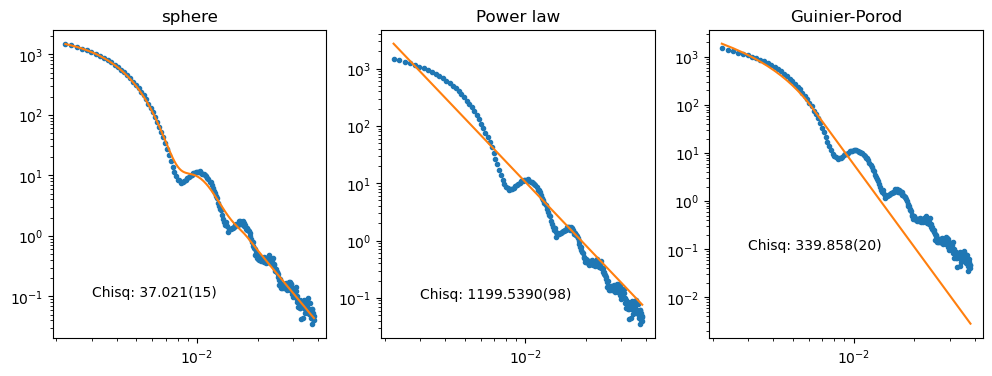

In [18]:
signal = sample_data['01cddefc-e6a6-41aa-9052-06286b12b8fe']
background = uuid2bkg['01cddefc-e6a6-41aa-9052-06286b12b8fe']

results = saxs_fit_monofunc(signal[0], background[0])

In [19]:
results

{'sphere_results': {'radius': 518.3155494827687,
  'radius_uncertainty': 0.3433644761769402,
  'radius_pd': 0.1612256278602821,
  'radius_pd_uncertainty': 0.000618140034142046,
  'scale': 0.0010716549375984772,
  'scale_uncertainty': 9.441155469985499e-07,
  'chisq': '37.021(15)'},
 'power_law_results': {'power': 3.6854214069558937,
  'power_uncertainty': 0.0015896285265973294,
  'scale': 4.4841490357240785e-07,
  'scale_uncertainty': 3.9764476005409e-09,
  'chisq': '1199.5390(98)'},
 'guinierporod_results': {'porod_exp': 5.715295268094689,
  'porod_exp_uncertainty': 0.013595896025767955,
  'rg': 343.12782854166153,
  'rg_uncertainty': 1.9159011149977832,
  's': 1.0183726048432478,
  's_uncertainty': 0.011007334538507075,
  'scale': 4.999999999999959,
  'scale_uncertainty': 0.3356846753621801,
  'chisq': '339.858(20)'}}

Fitting sample 0
Fitting sample 1
Fitting sample 2
Fitting sample 3


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:133: UserWarning: Failed to find region of valid data (low q limit not found). Check that your sample scatters reasonably well
  warnings.warn(
/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:197: UserWarning: Issue during data selection, check data quality
  warnings.warn('Issue during data selection, check data quality')
/tmp/ipykernel_55849/67515113.py:6: UserWarning: Subtracted data is none, passing
  warnings.warn('Subtracted data is none, passing')


Fitting sample 4
Fitting sample 5
Fitting sample 6
Fitting sample 7
Fitting sample 8
Fitting sample 9
Fitting sample 10
Fitting sample 11
Fitting sample 12
Fitting sample 13
Fitting sample 14
Fitting sample 15
Fitting sample 16
Fitting sample 17
Fitting sample 18
Fitting sample 19
Fitting sample 20
Fitting sample 21


/tmp/ipykernel_55849/67515113.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,3, figsize = (12,4))


Fitting sample 22
Fitting sample 23
Fitting sample 24
Fitting sample 25
Fitting sample 26
Fitting sample 27
Fitting sample 28
Fitting sample 29
Fitting sample 30
Fitting sample 31
Fitting sample 32
Fitting sample 33
Fitting sample 34
Fitting sample 35
Fitting sample 36
Fitting sample 37
Fitting sample 38
Fitting sample 39
Fitting sample 40
Fitting sample 41
Fitting sample 42
Fitting sample 43
Fitting sample 44
Fitting sample 45
Fitting sample 46
Fitting sample 47
Fitting sample 48


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:138: UserWarning: Insufficient data points in q range with scattering. Check data quality
  warnings.warn(


Fitting sample 49
Fitting sample 50
Fitting sample 51
Fitting sample 52
ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''
Fitting sample 53
Fitting sample 54
Fitting sample 55
Fitting sample 56
Fitting sample 57
Fitting sample 58
Fitting sample 59
Fitting sample 60


/home/bgpelkie/Code/sasmodels/sasmodels/models/guinier_porod.py:116: RuntimeWarning: invalid value encountered in sqrt
  idx = q < sqrt(n*ms)/rg
/home/bgpelkie/Code/sasmodels/sasmodels/models/guinier_porod.py:119: RuntimeWarning: invalid value encountered in scalar power
  iq[~idx] = q[~idx]**-porod_exp * (exp(-ms) * (n*ms/rg**2)**ms)


SVD did not converge
Fitting sample 61
Fitting sample 62
Fitting sample 63
Fitting sample 64
Fitting sample 65
Fitting sample 66
Fitting sample 67
Fitting sample 68
Fitting sample 69
Fitting sample 70
Fitting sample 71
Fitting sample 72
Fitting sample 73
Fitting sample 74
Fitting sample 75
Fitting sample 76
Fitting sample 77
Fitting sample 78
Fitting sample 79
Fitting sample 80
Fitting sample 81
Fitting sample 82
Fitting sample 83
Fitting sample 84
Fitting sample 85
Fitting sample 86
Fitting sample 87
Fitting sample 88
Fitting sample 89
Fitting sample 90
Fitting sample 91
Fitting sample 92
Fitting sample 93
Fitting sample 94
Fitting sample 95
Fitting sample 96
Fitting sample 97
Fitting sample 98
Fitting sample 99
Fitting sample 100


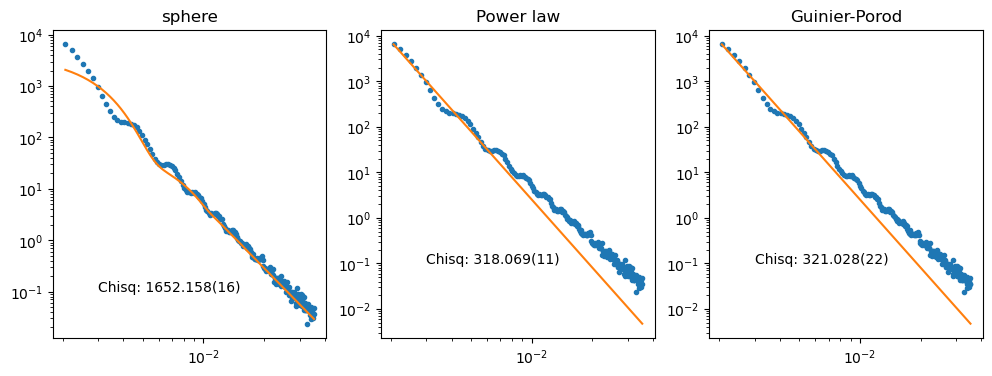

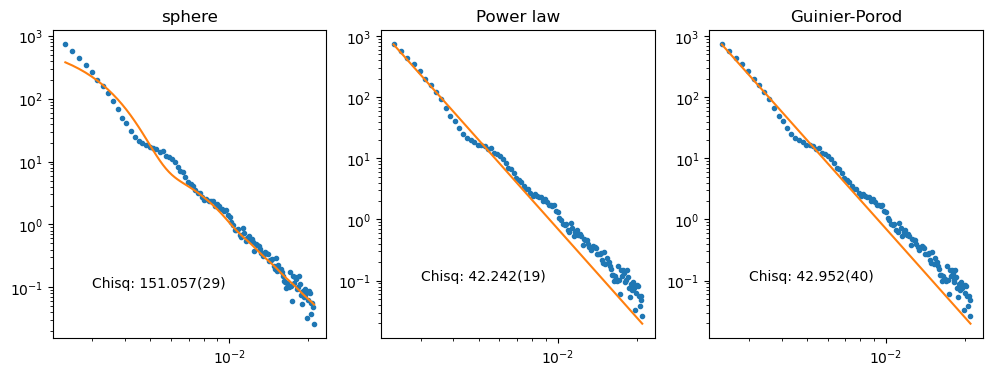

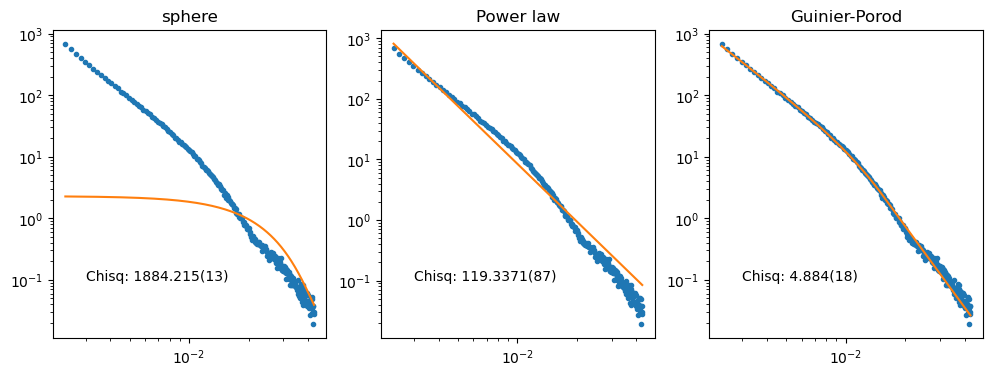

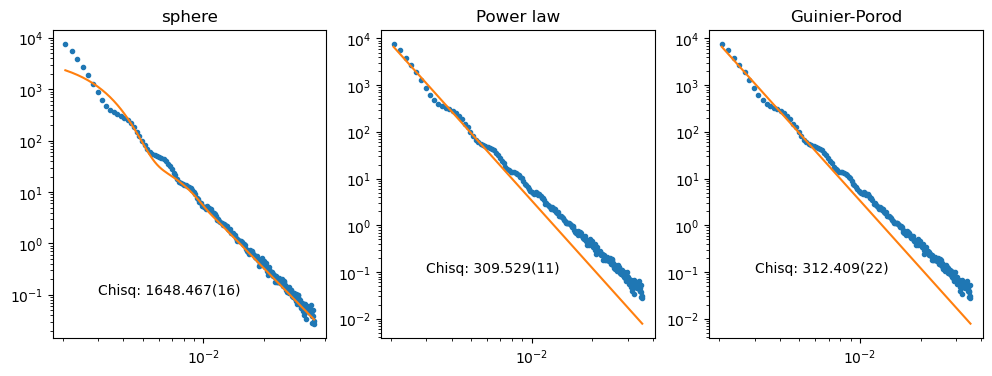

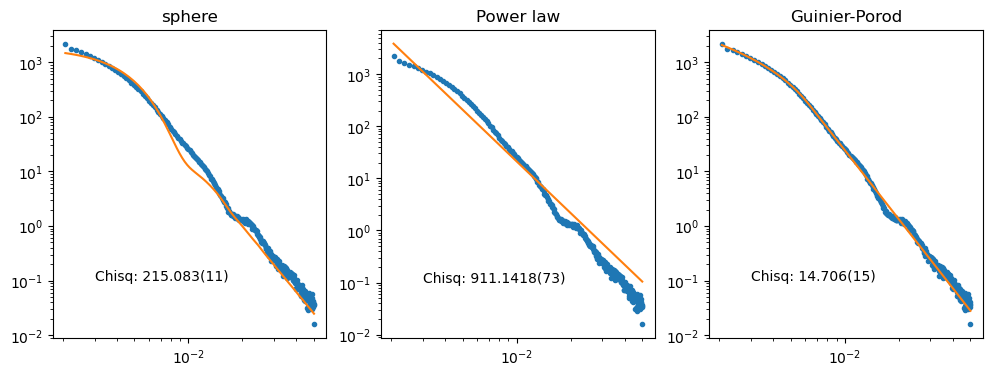

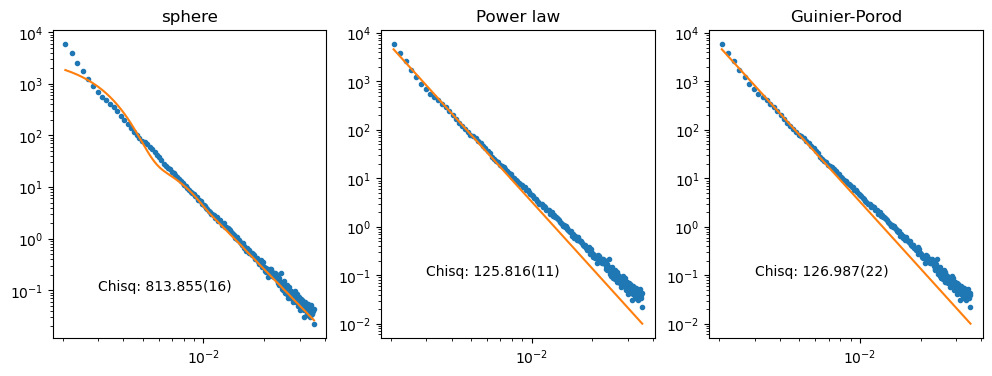

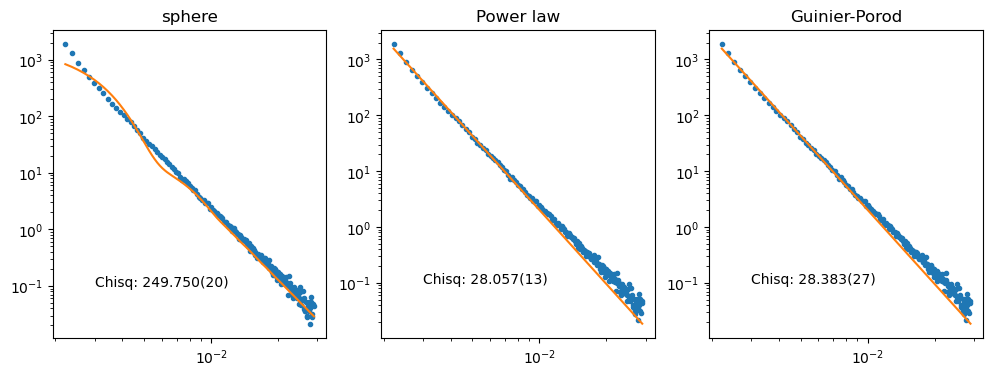

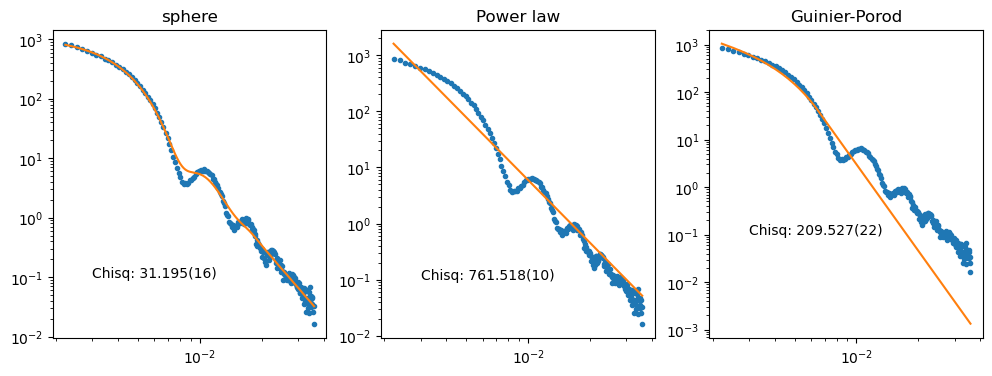

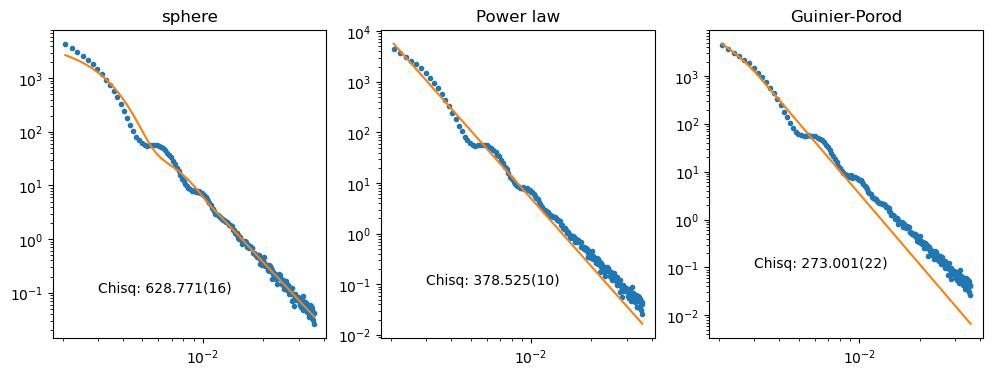

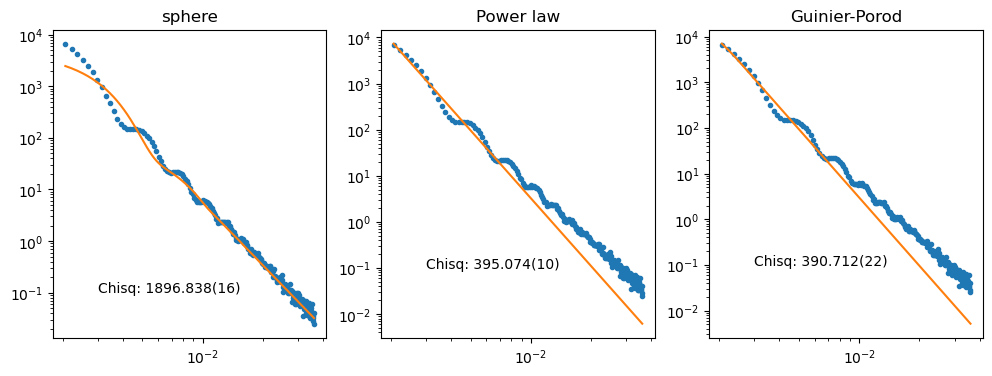

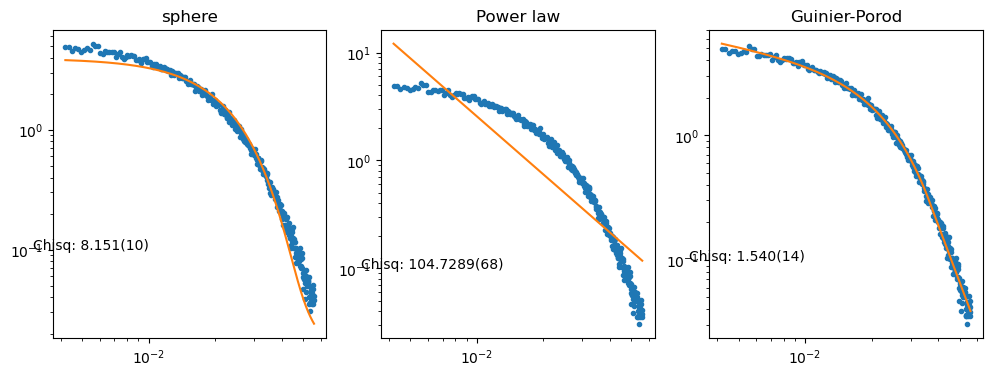

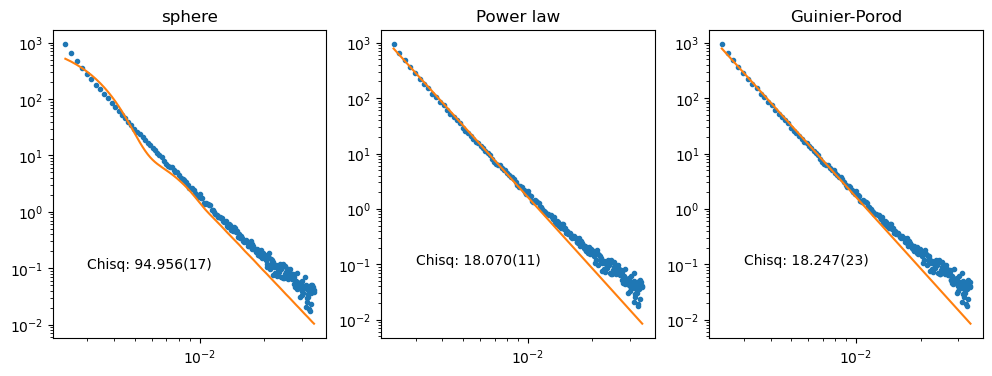

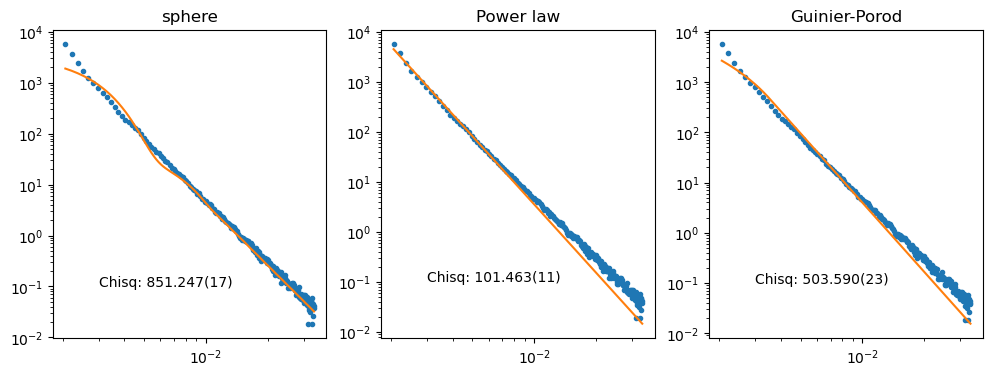

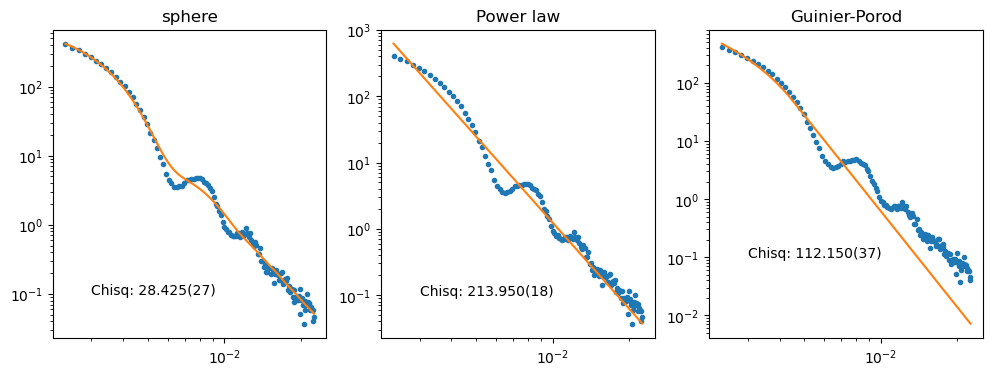

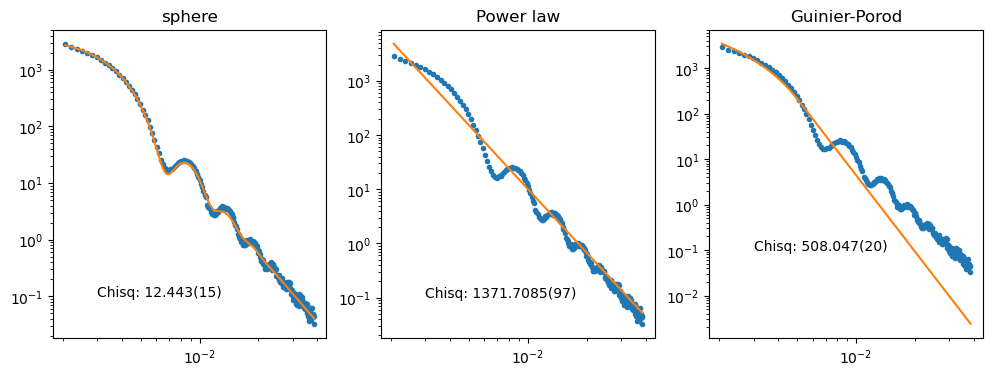

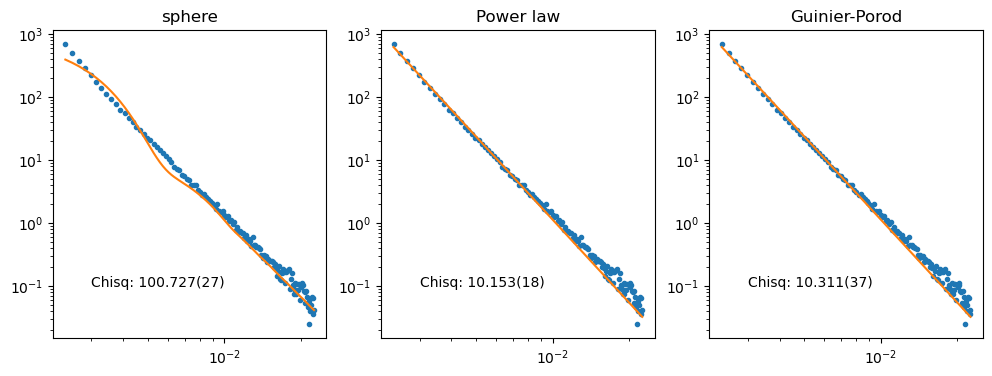

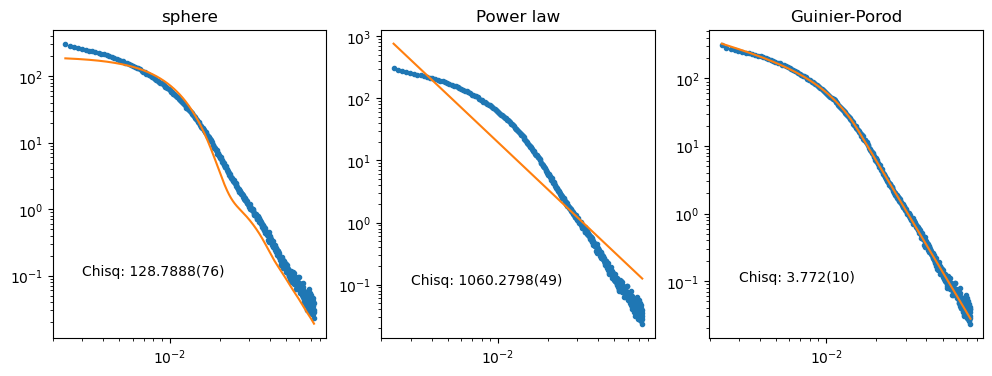

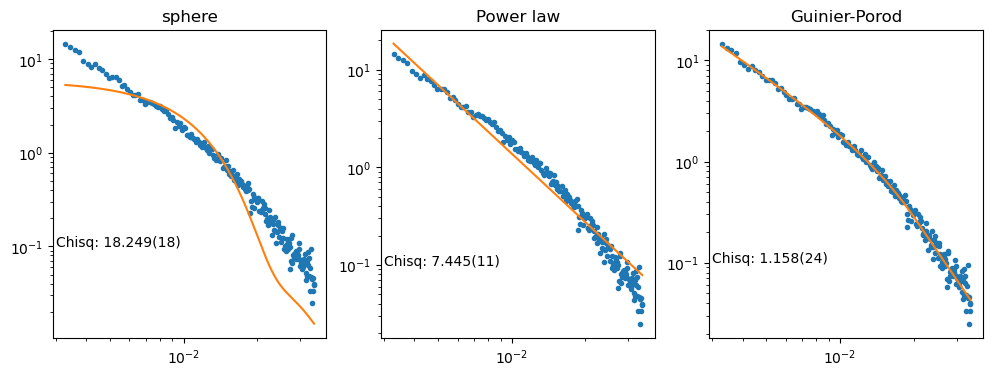

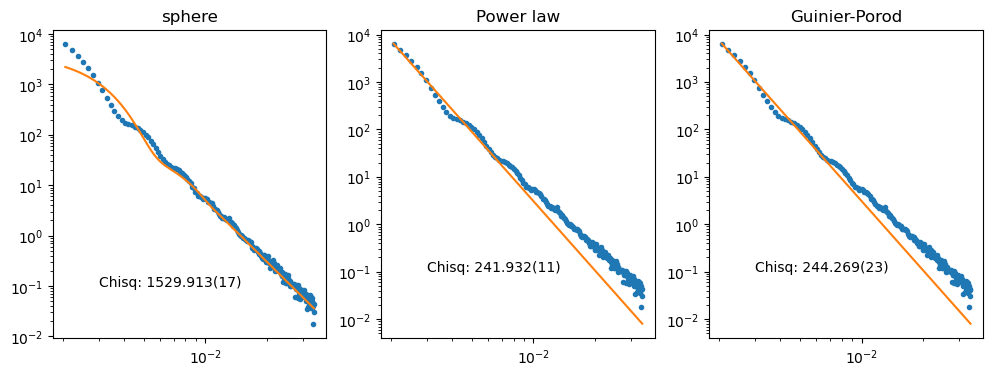

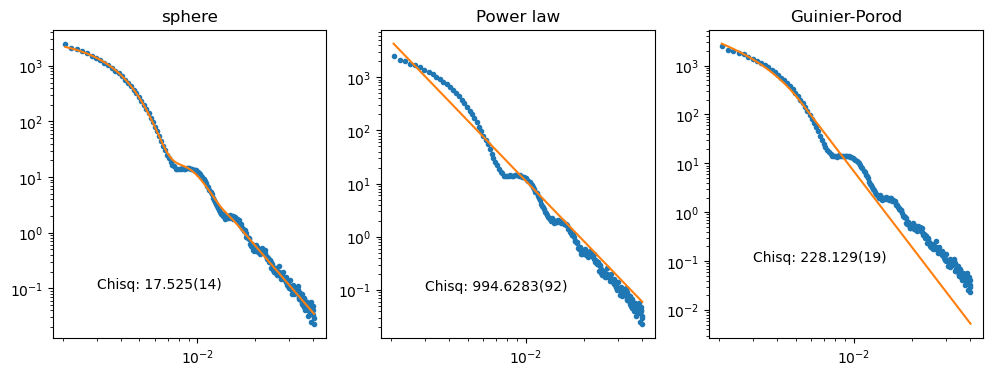

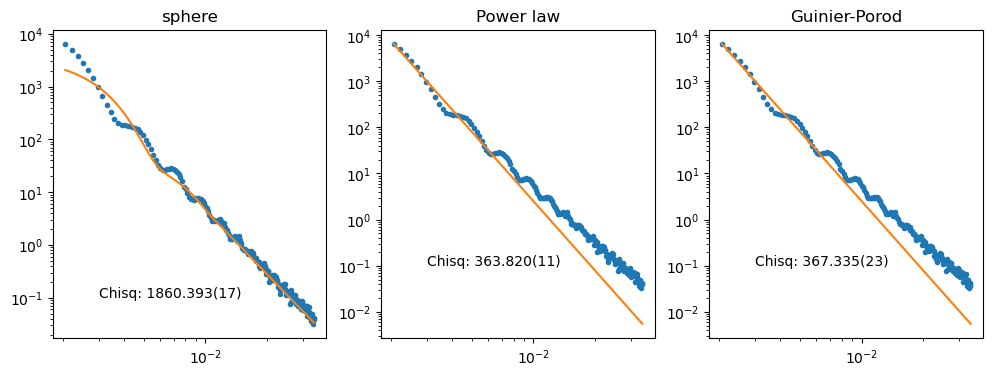

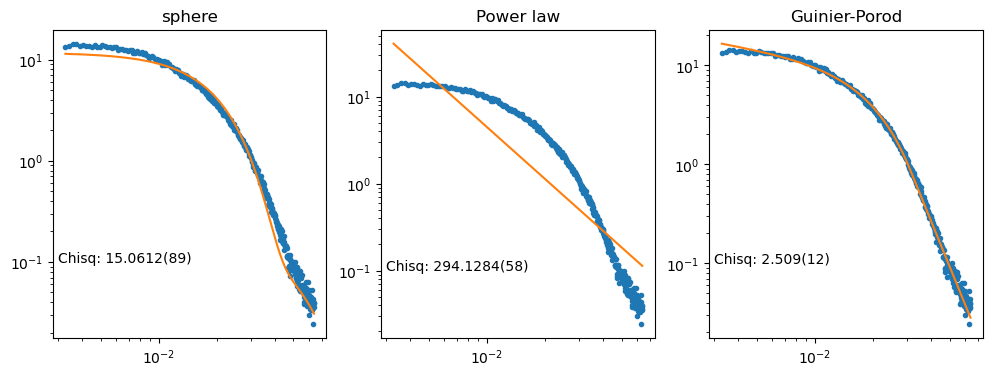

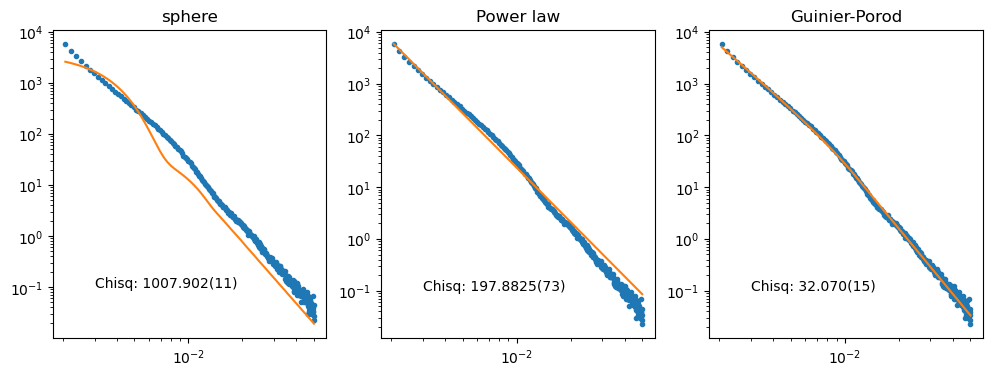

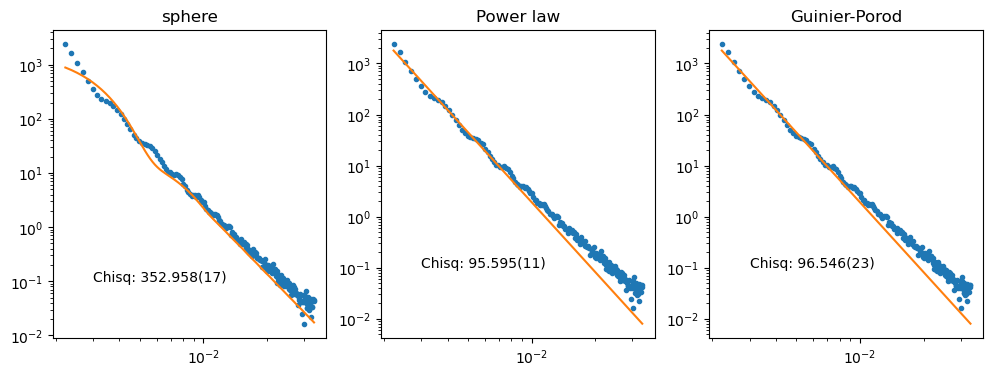

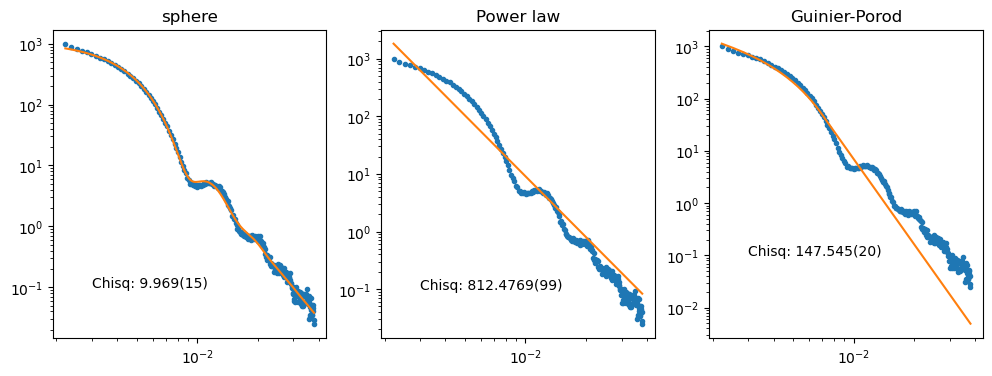

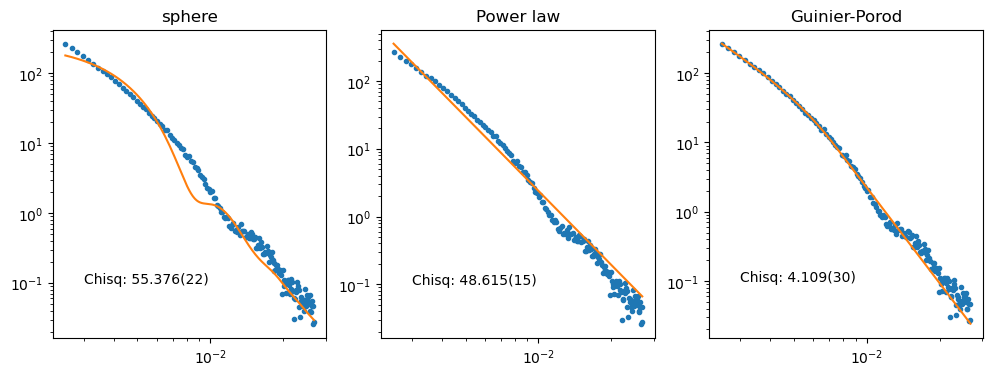

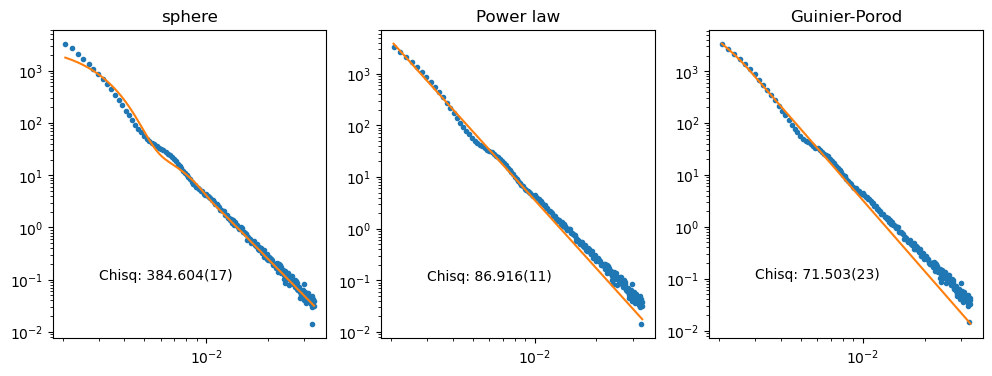

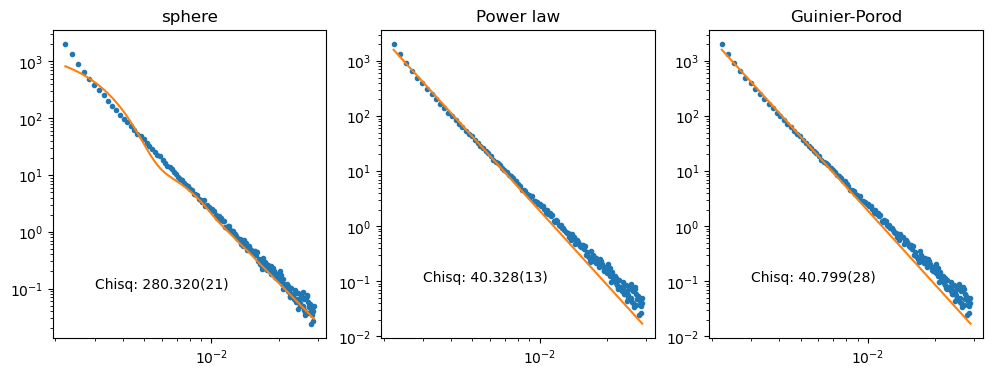

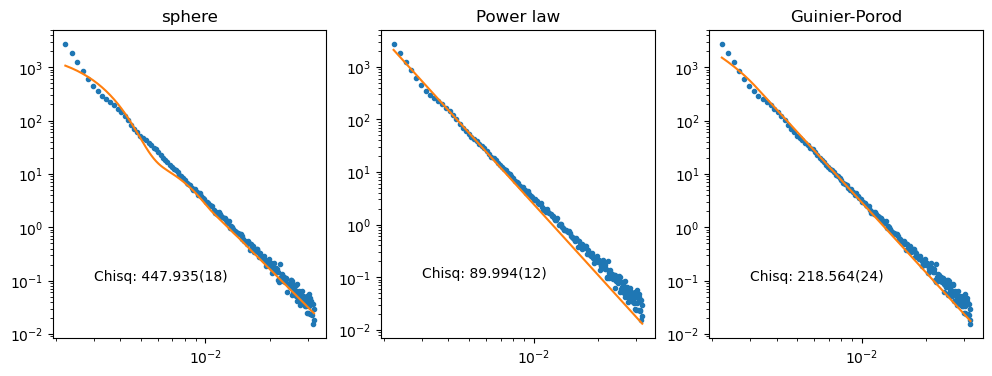

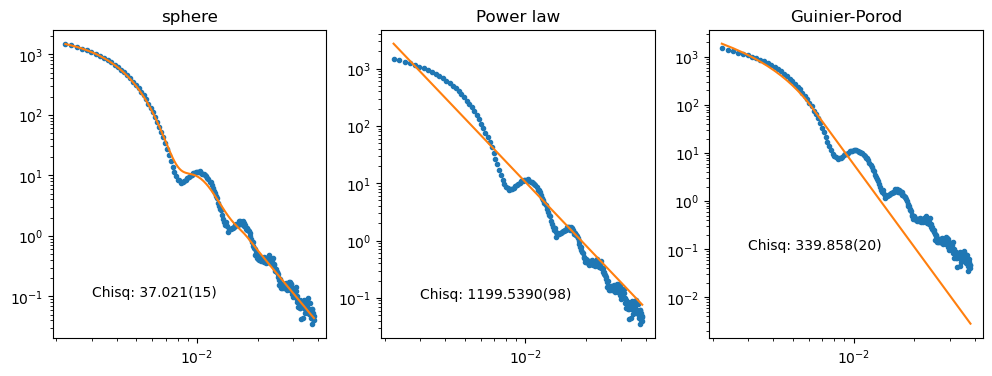

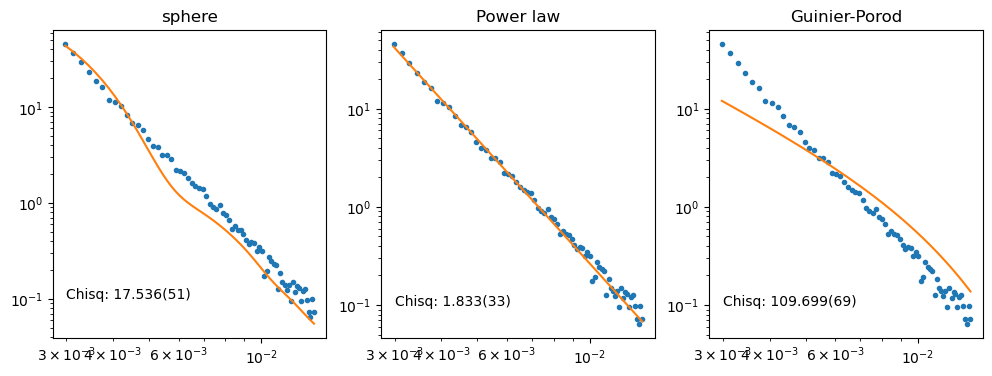

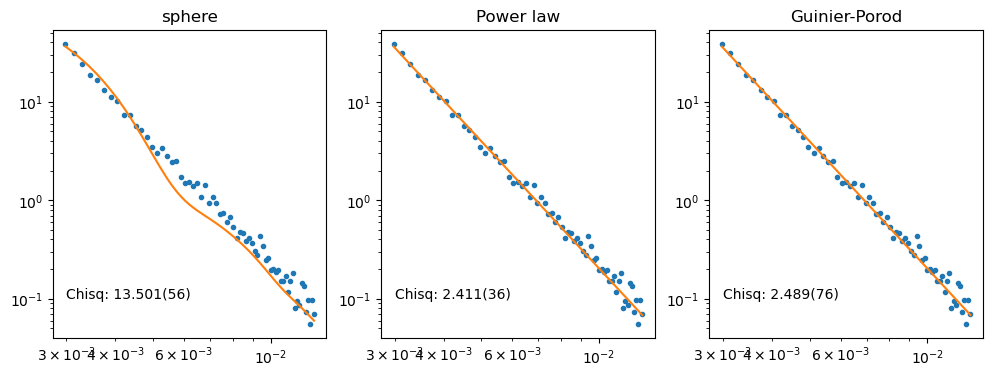

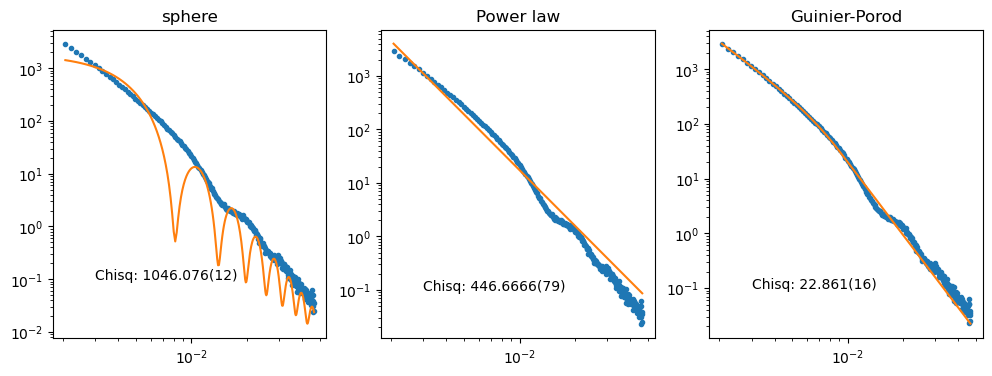

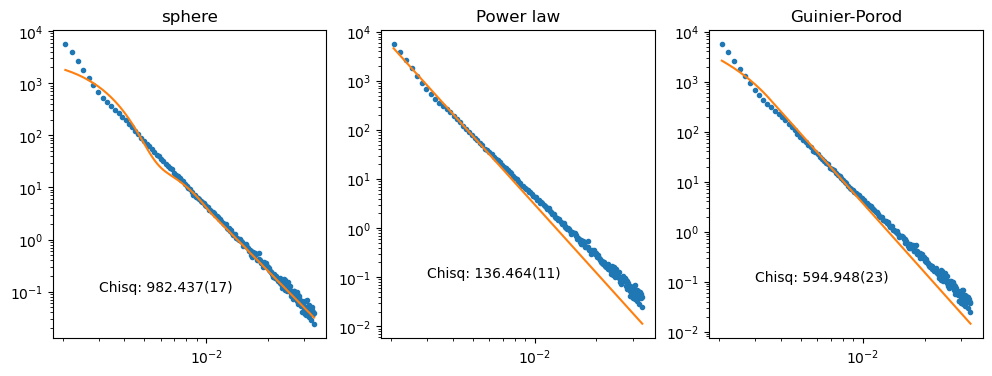

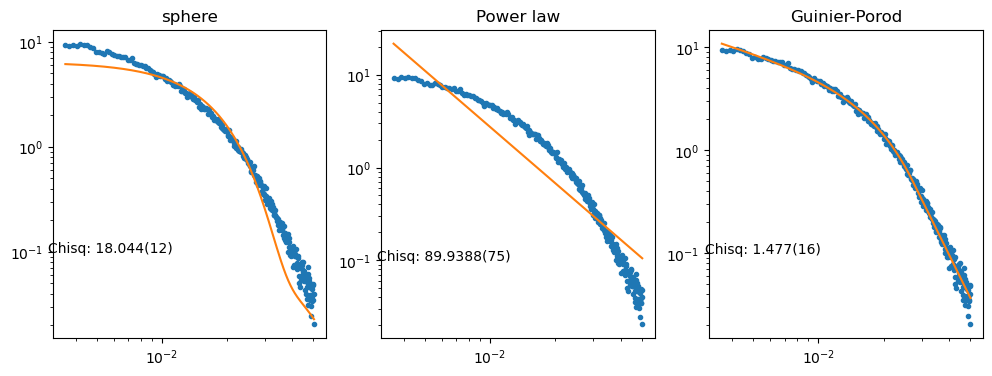

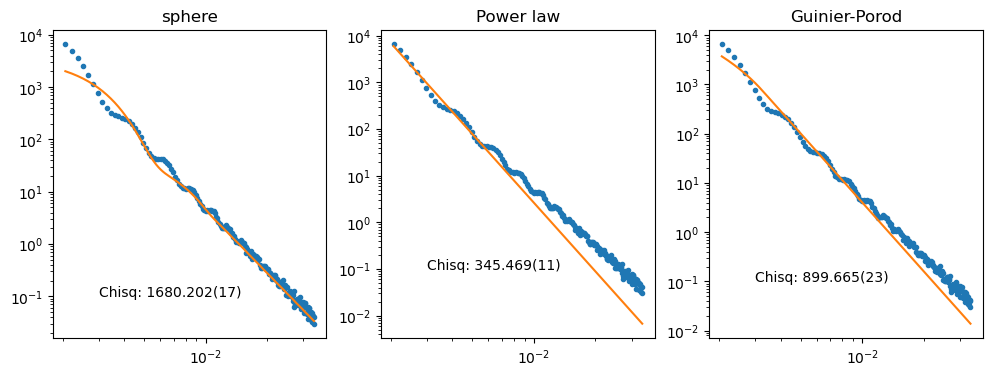

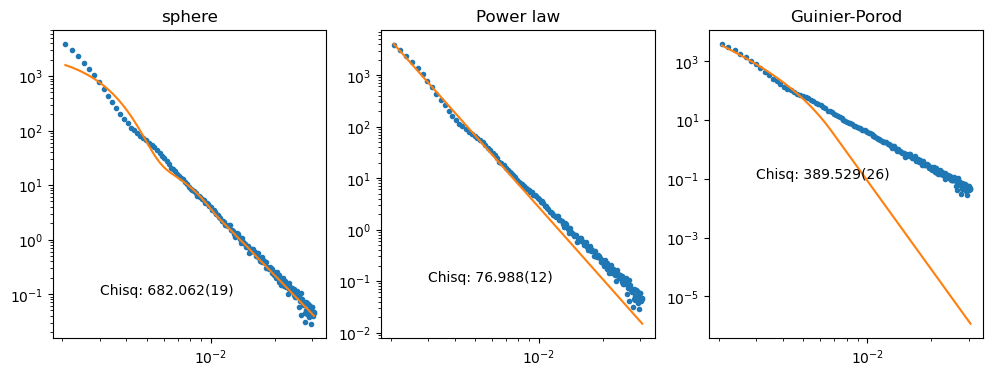

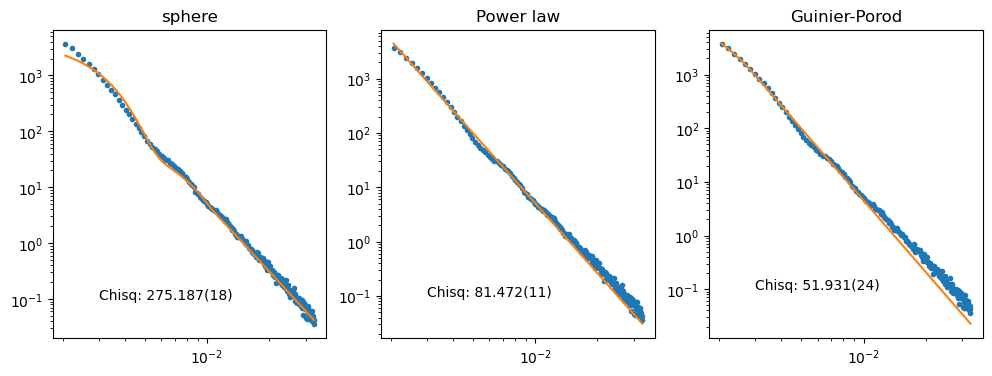

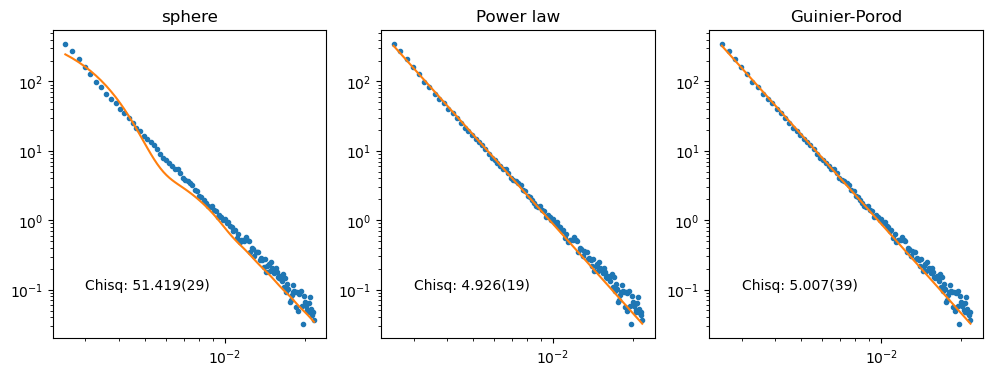

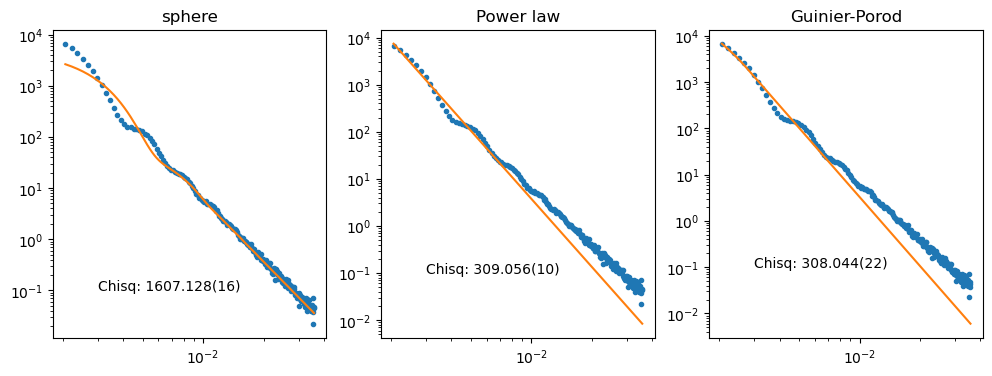

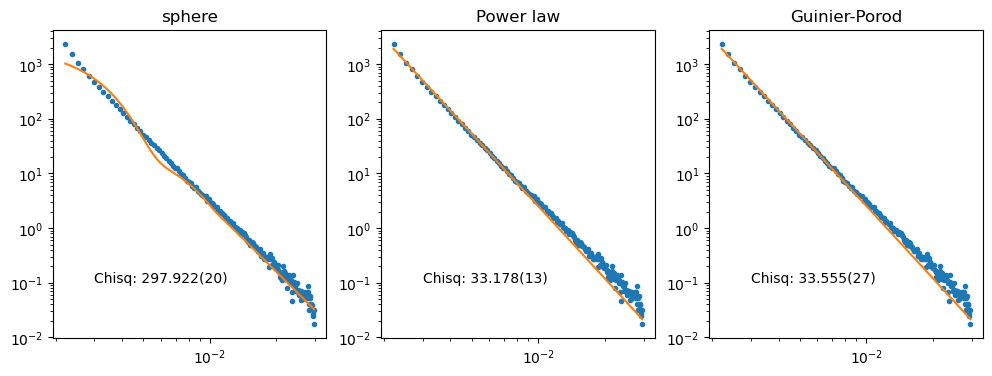

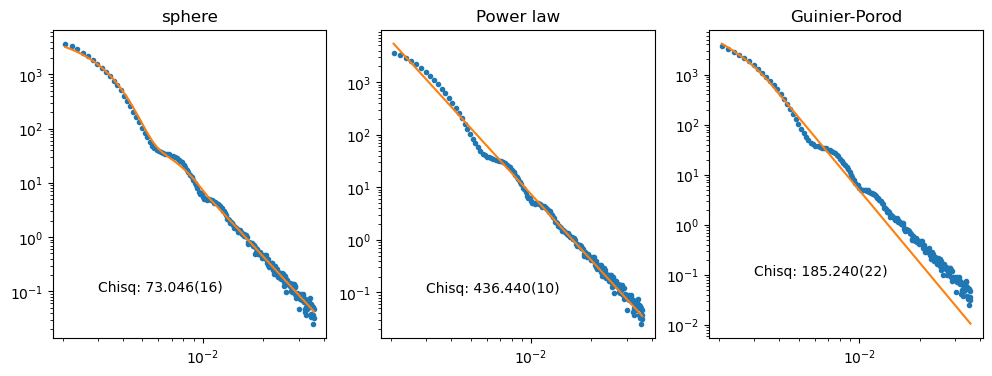

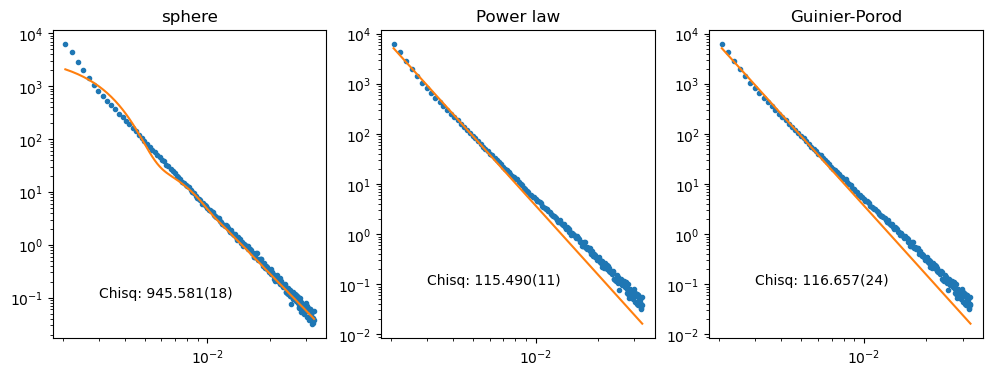

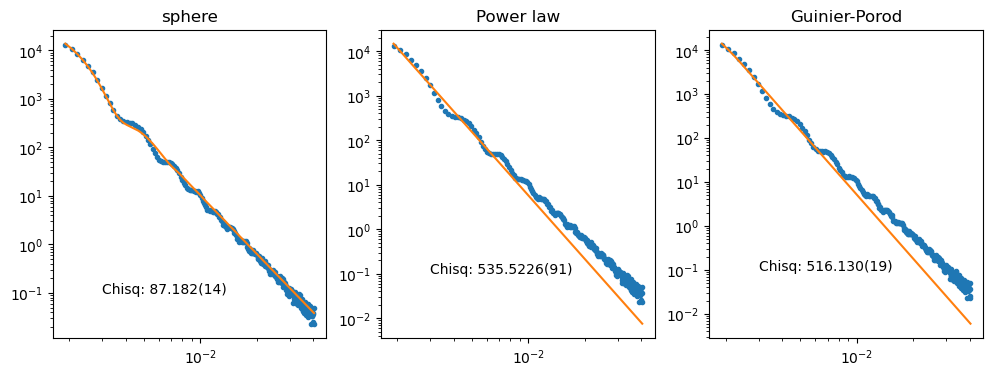

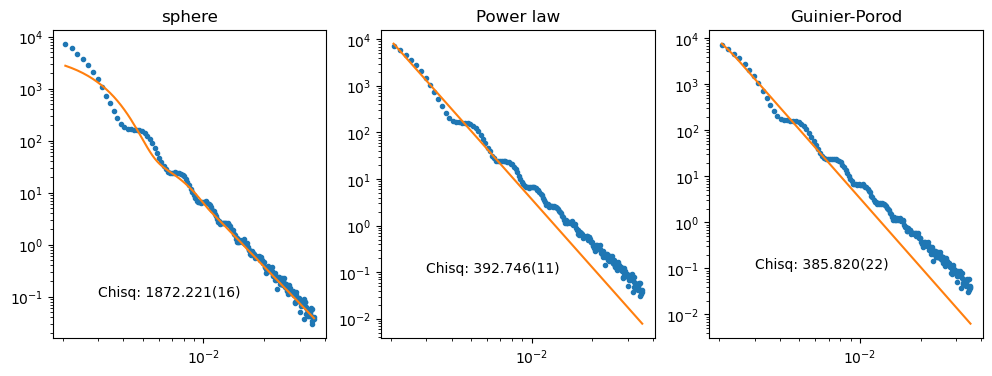

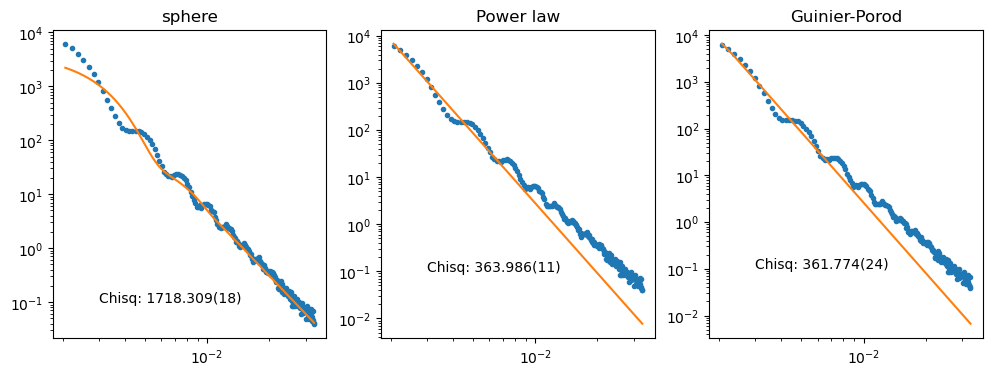

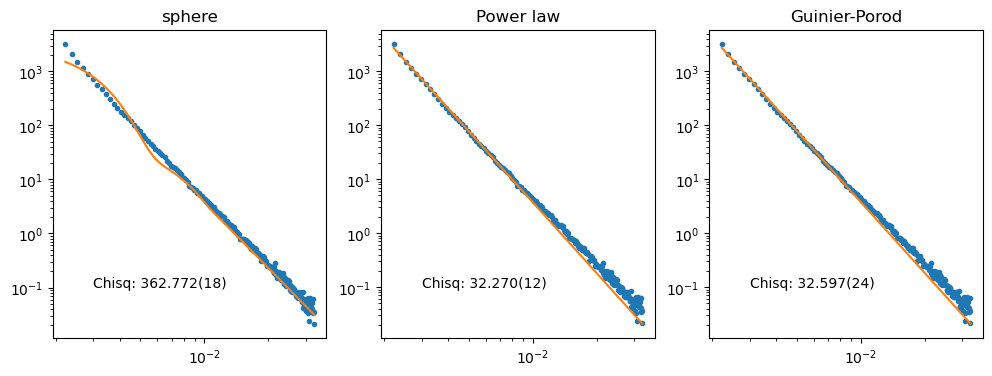

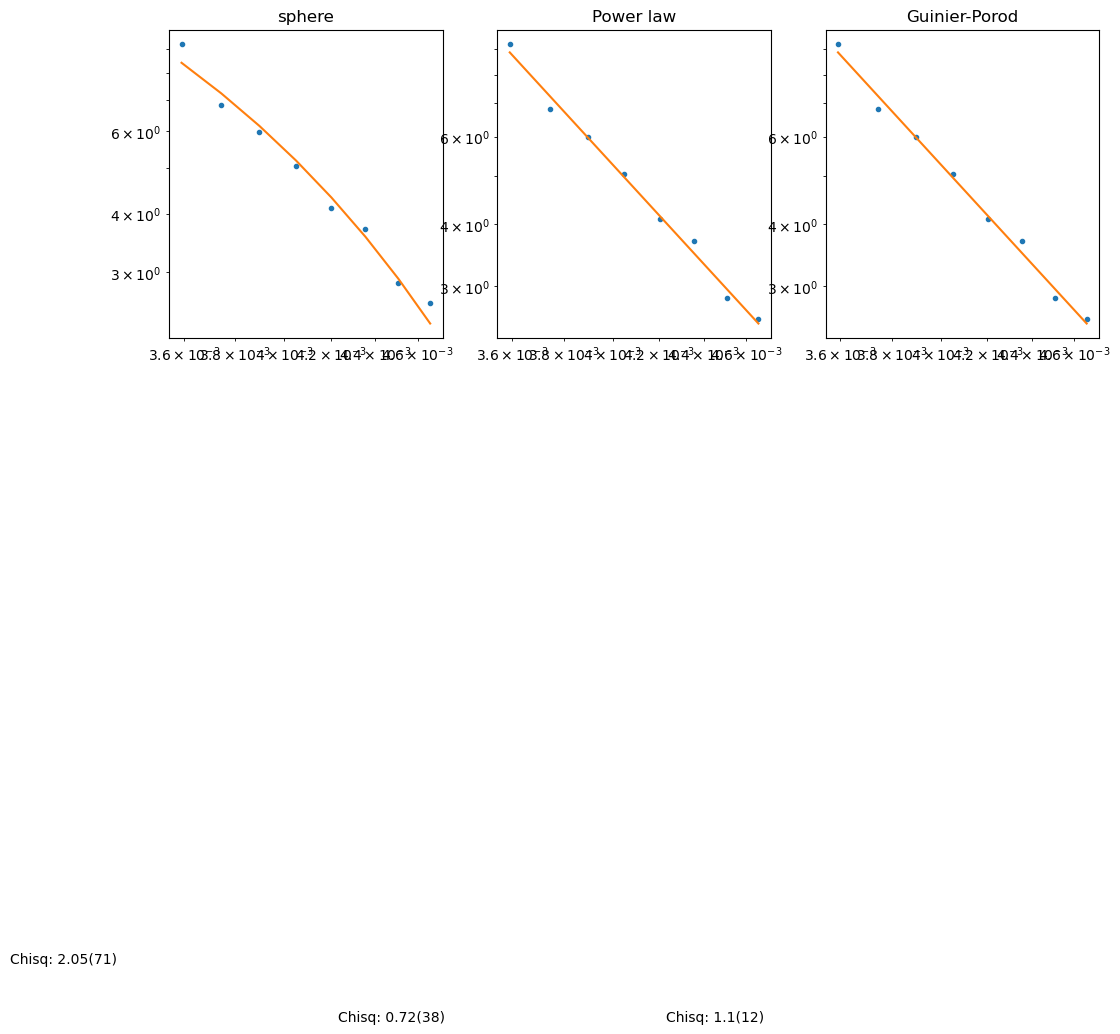

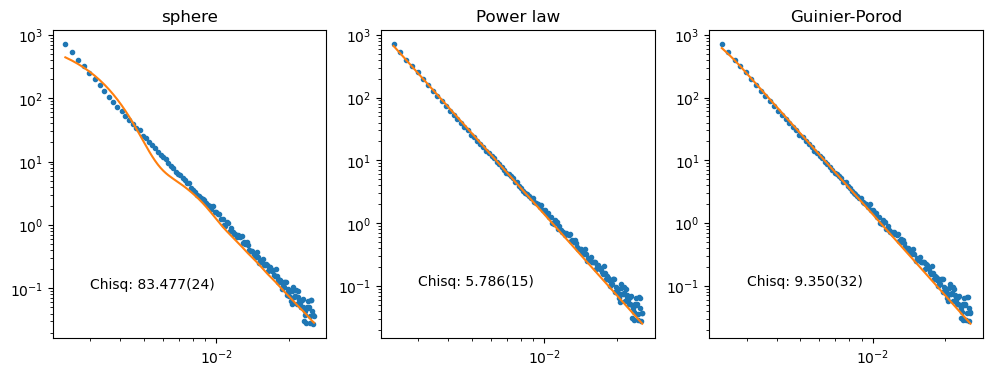

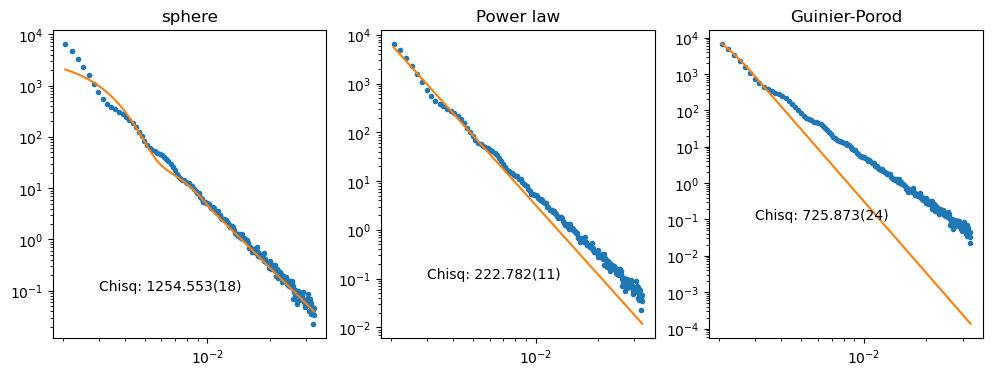

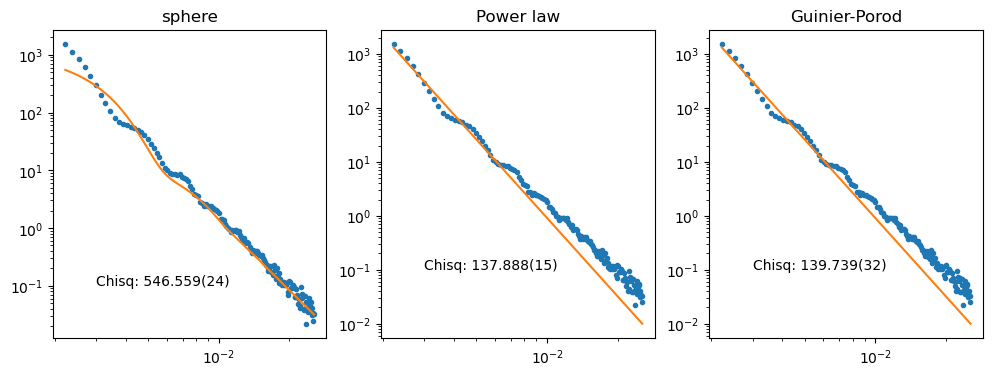

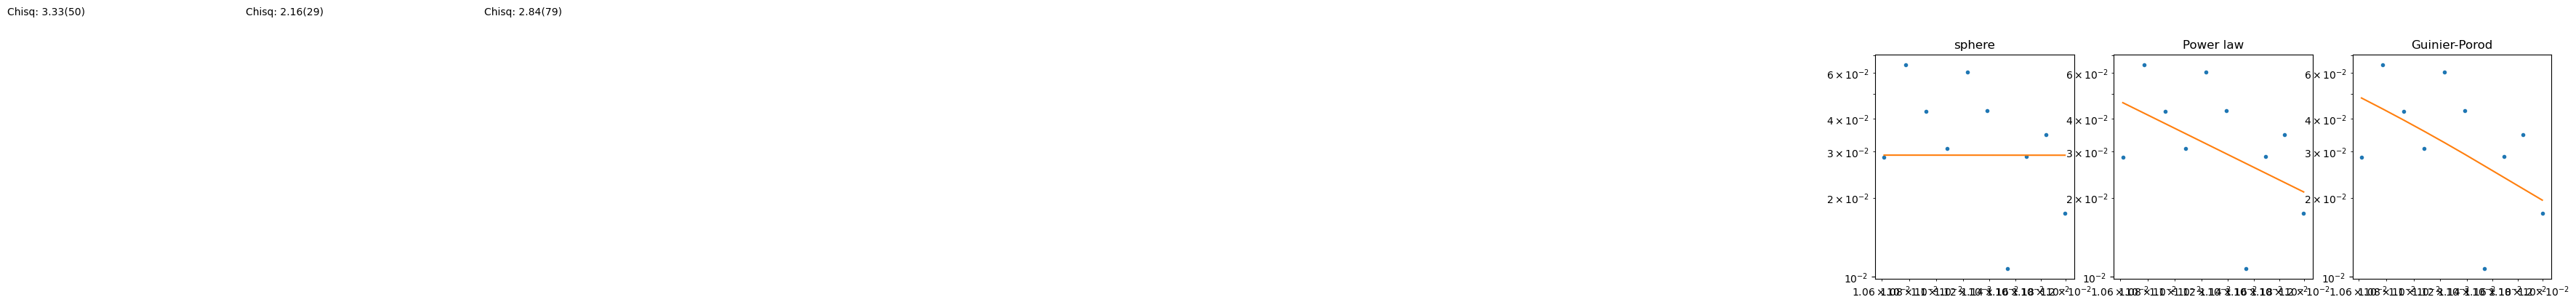

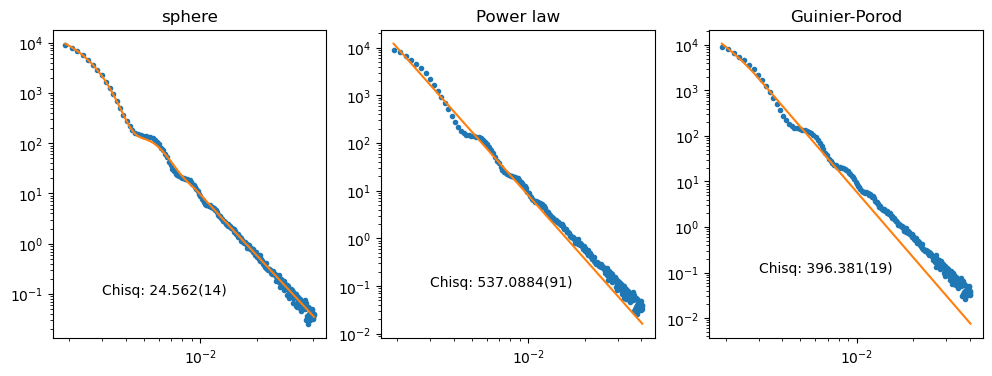

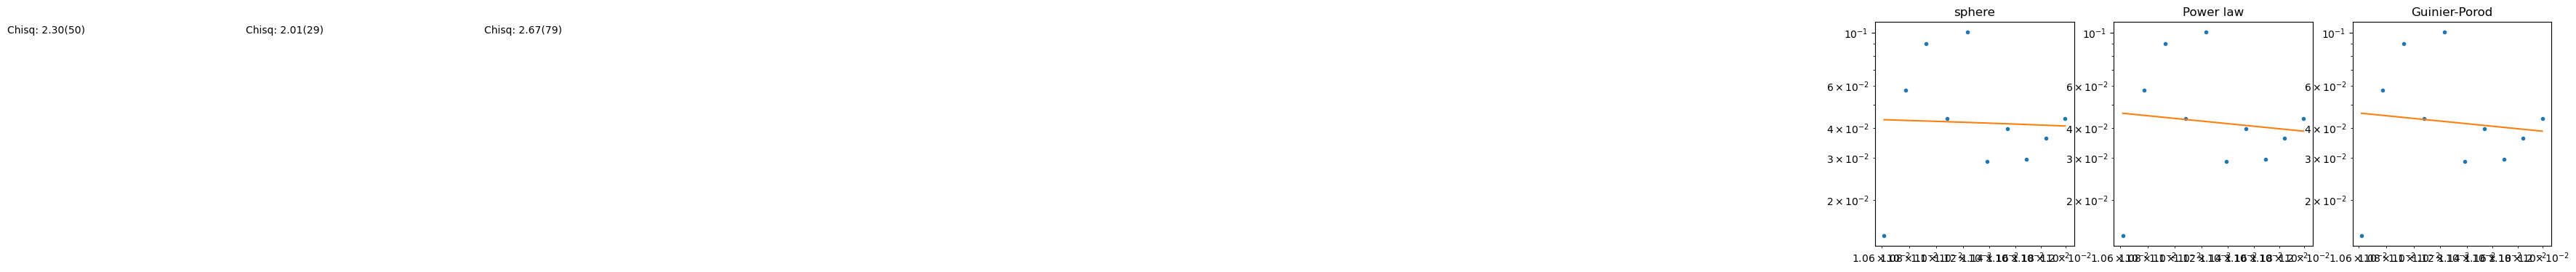

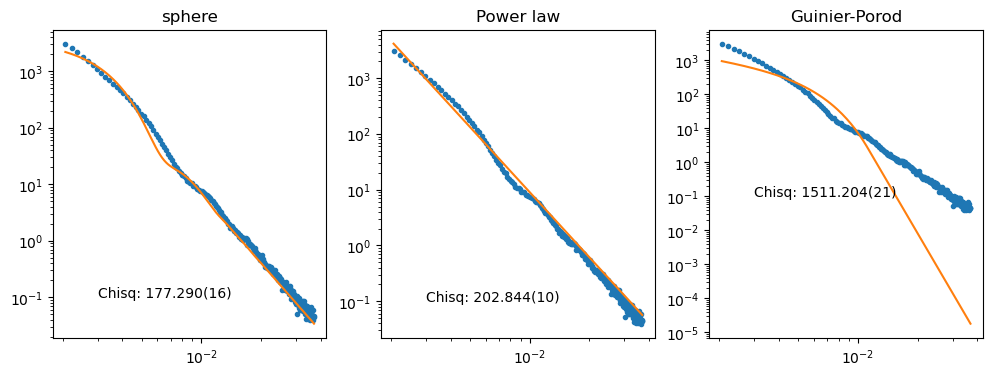

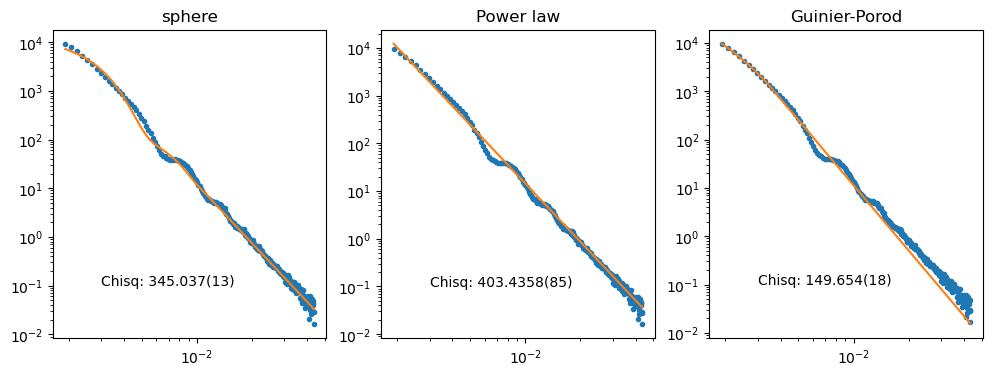

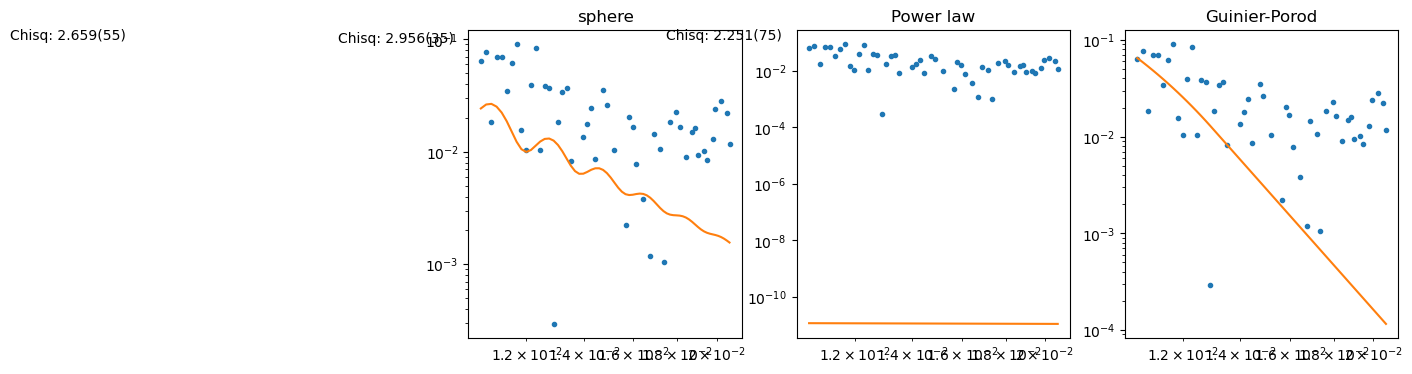

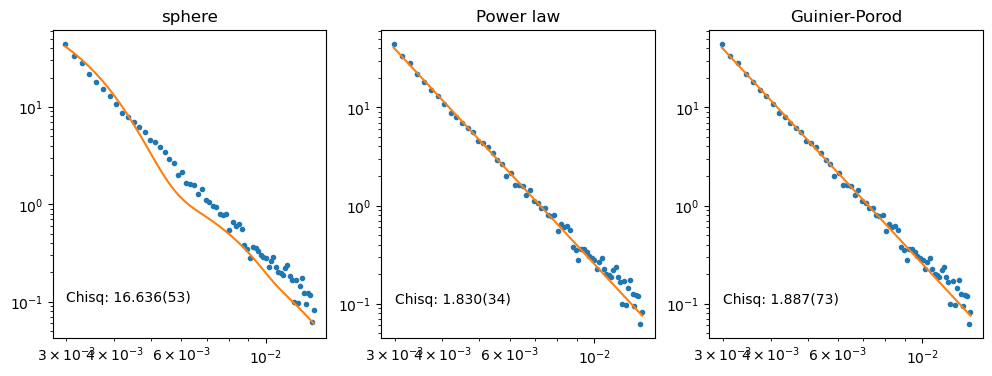

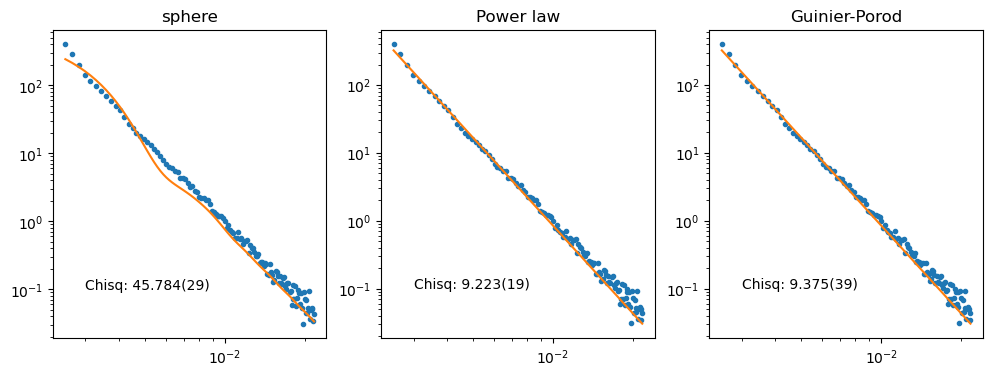

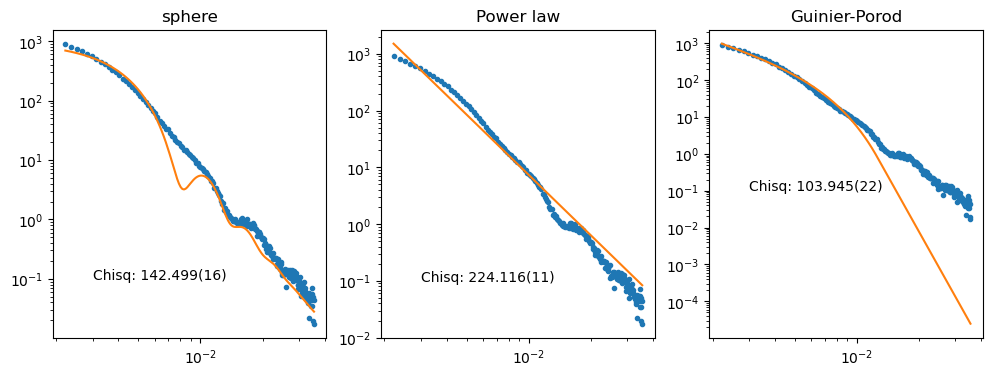

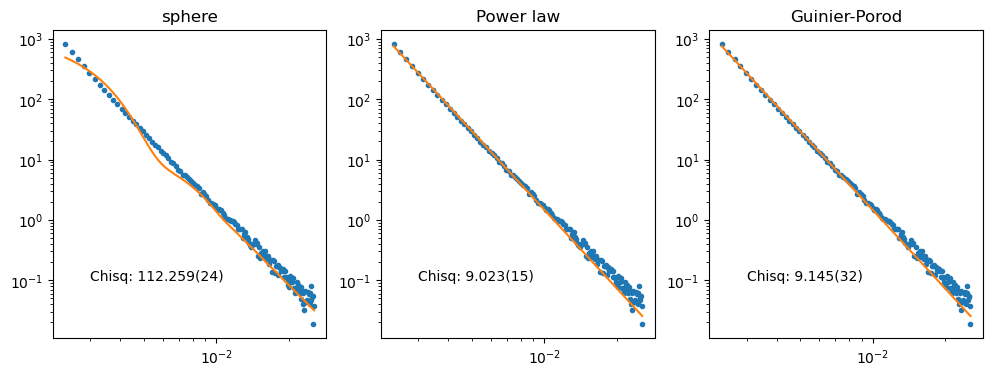

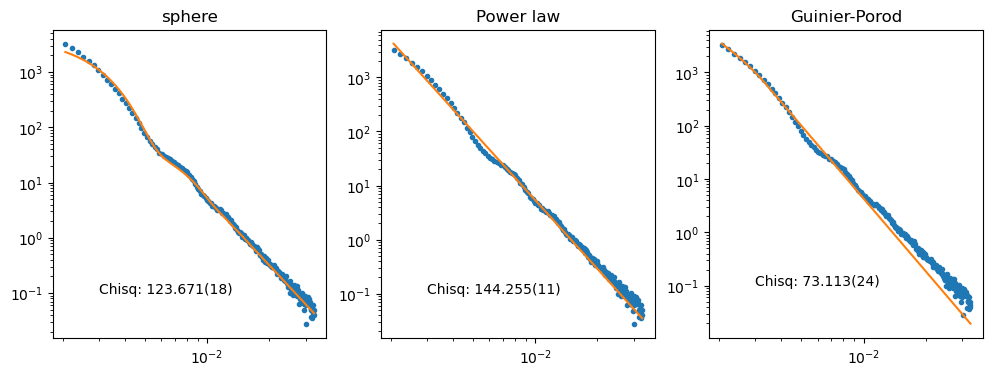

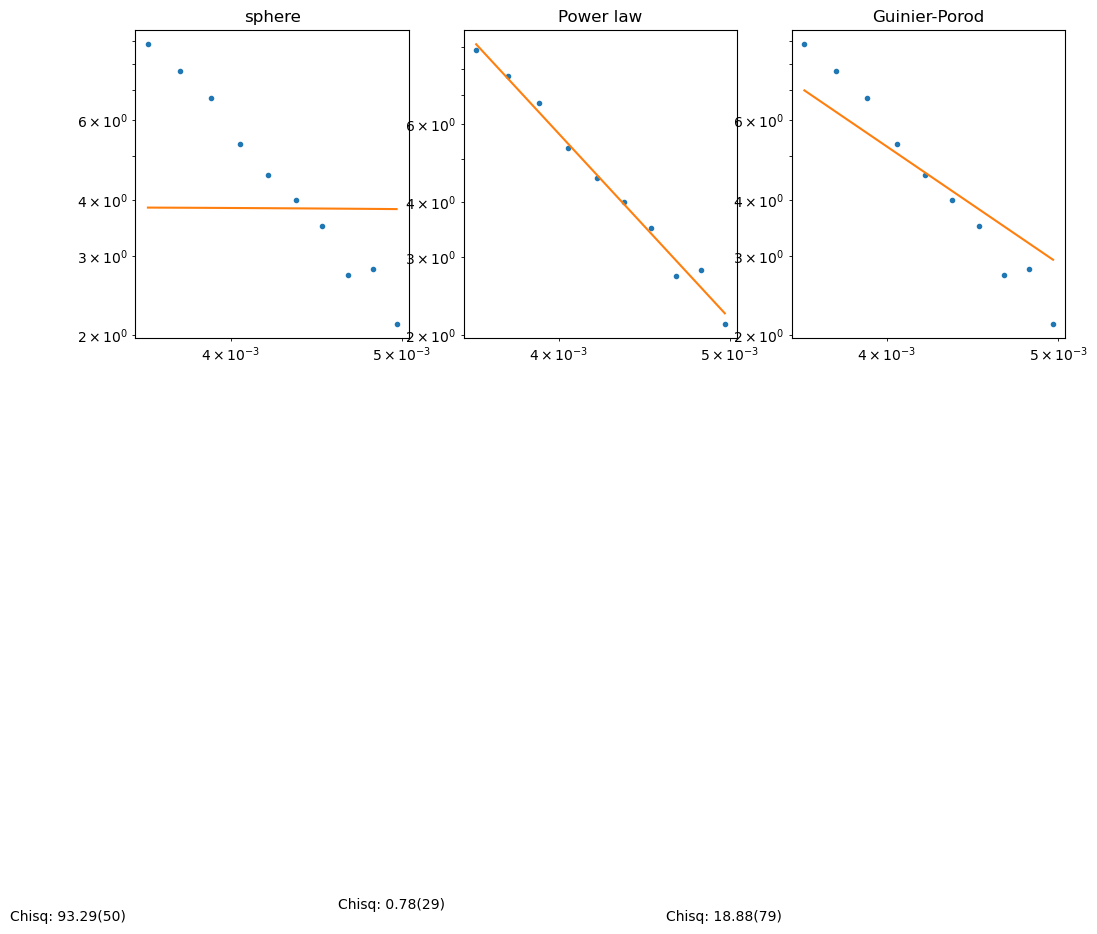

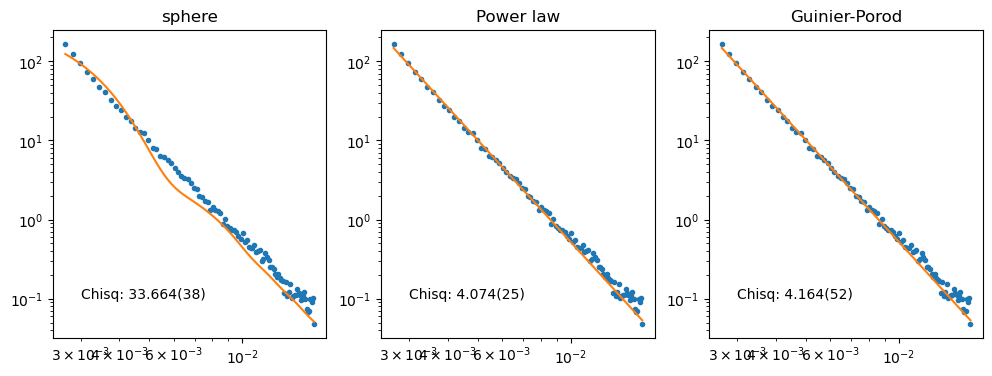

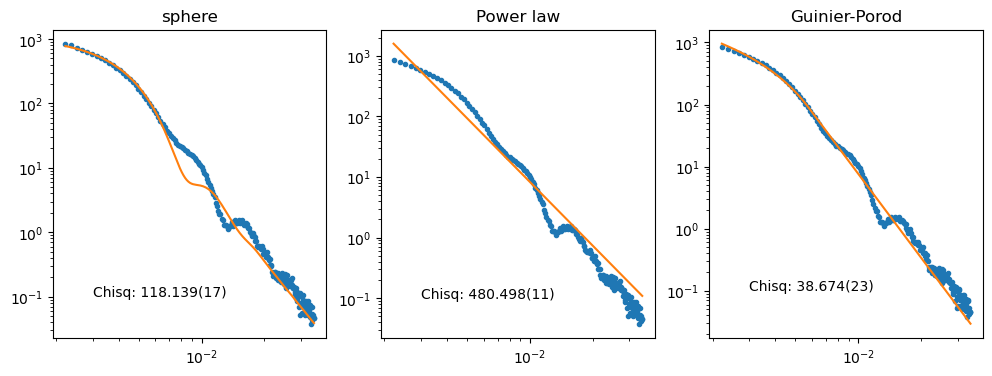

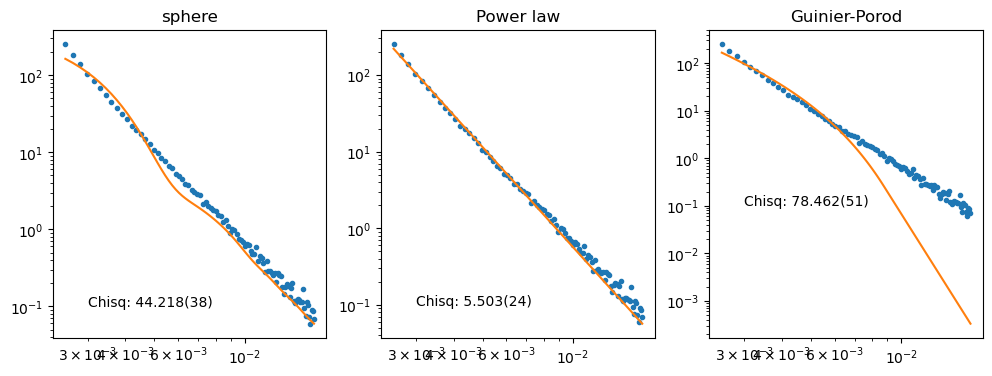

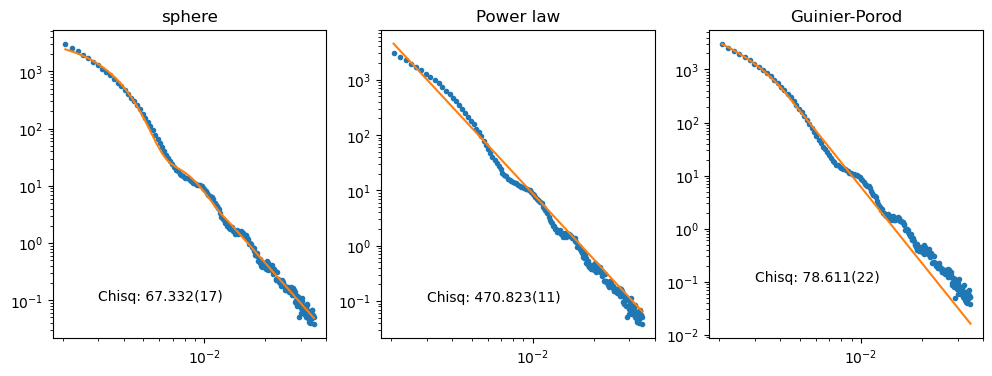

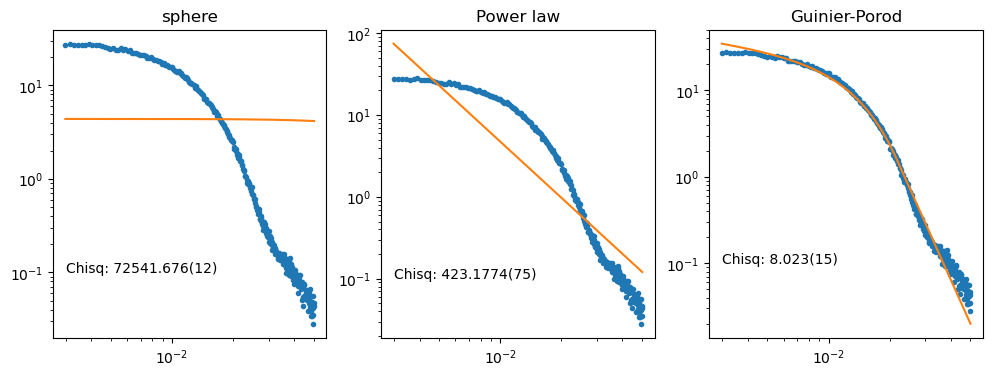

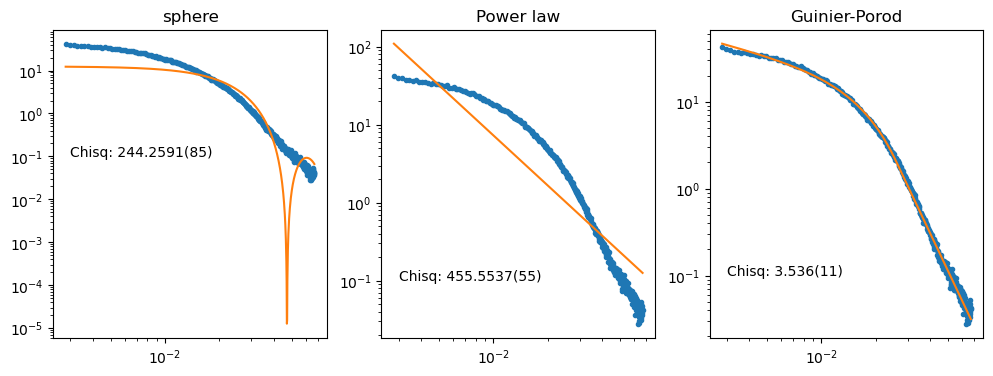

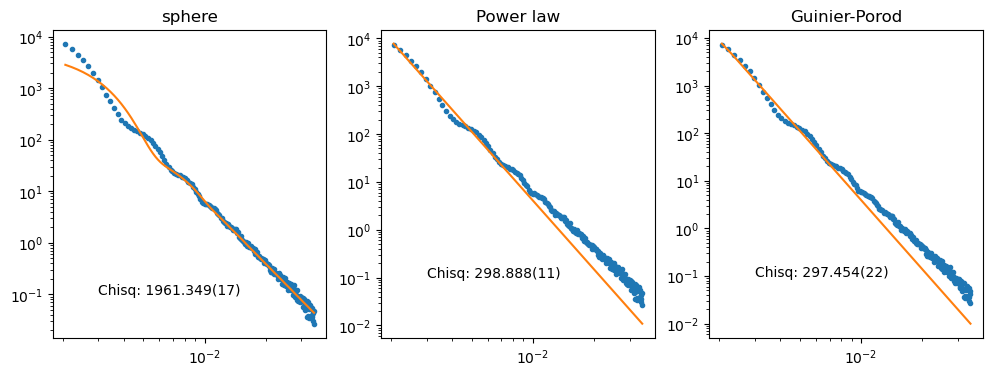

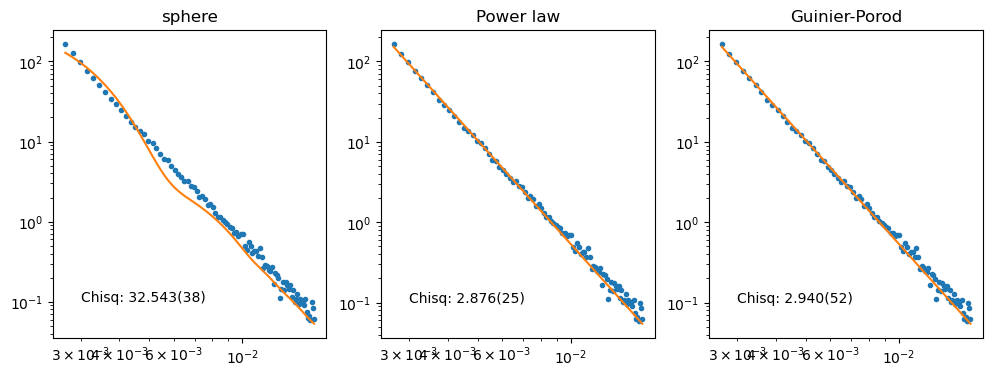

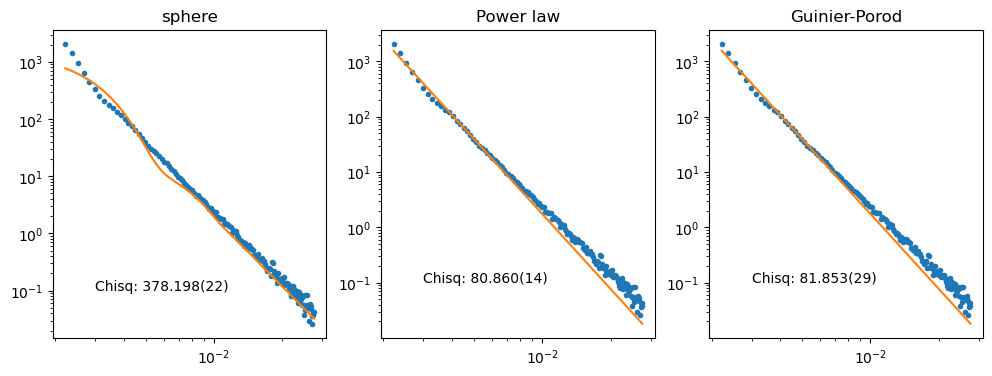

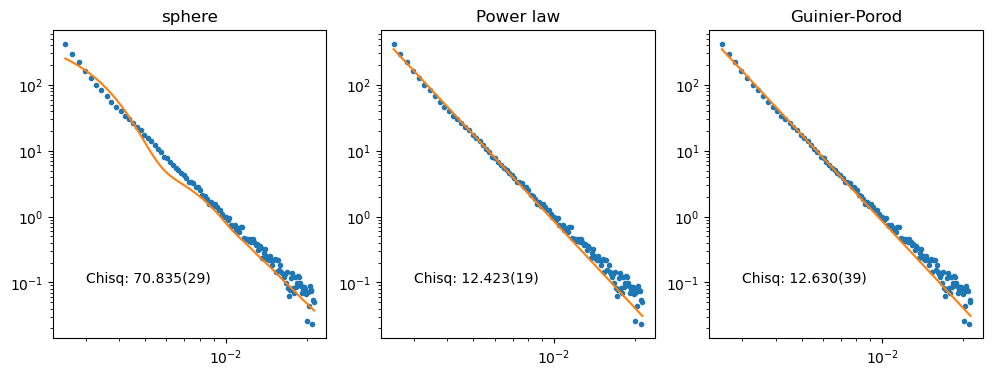

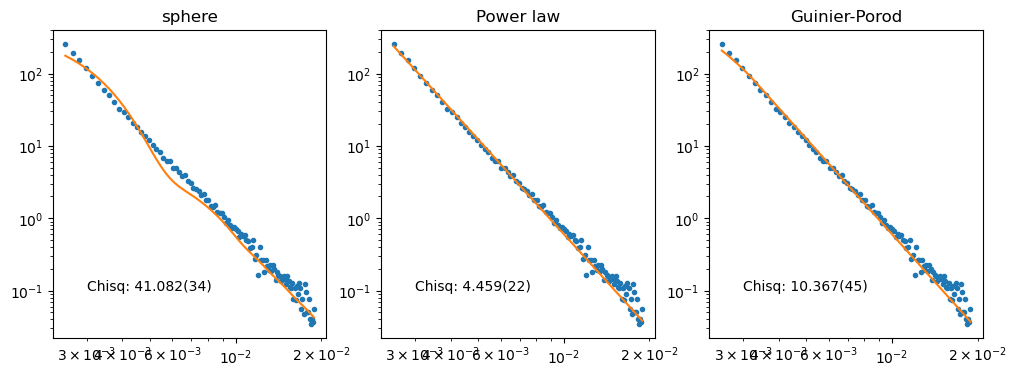

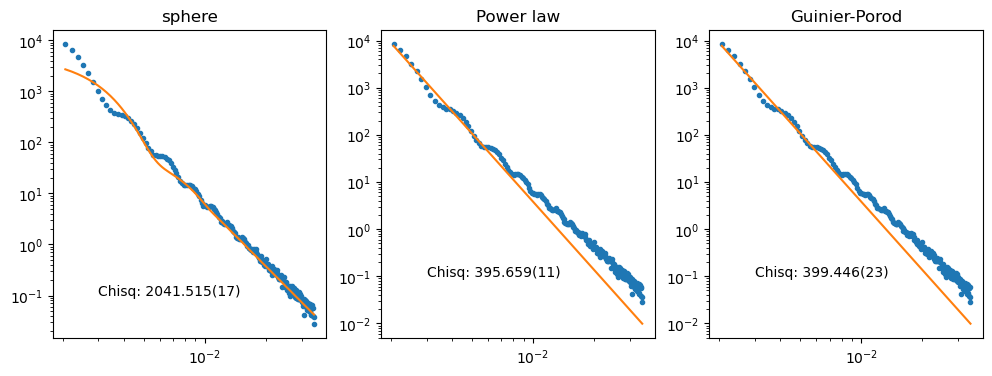

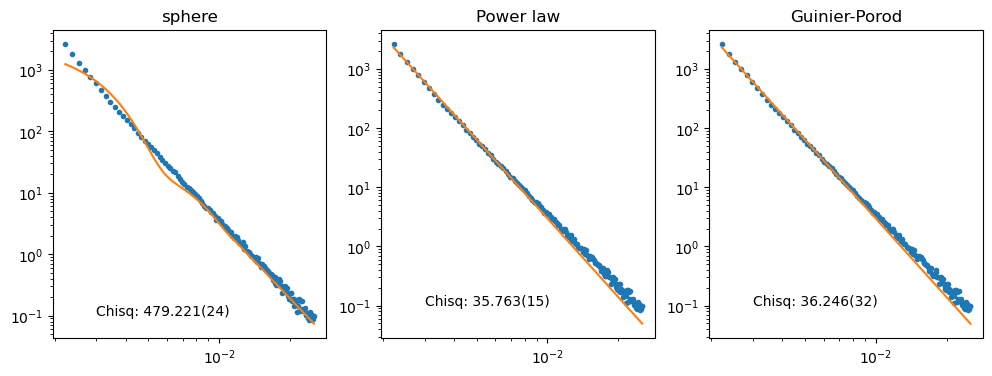

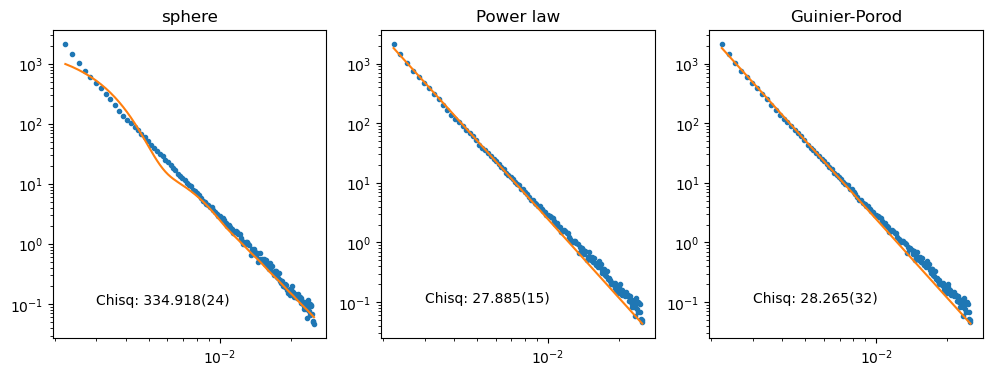

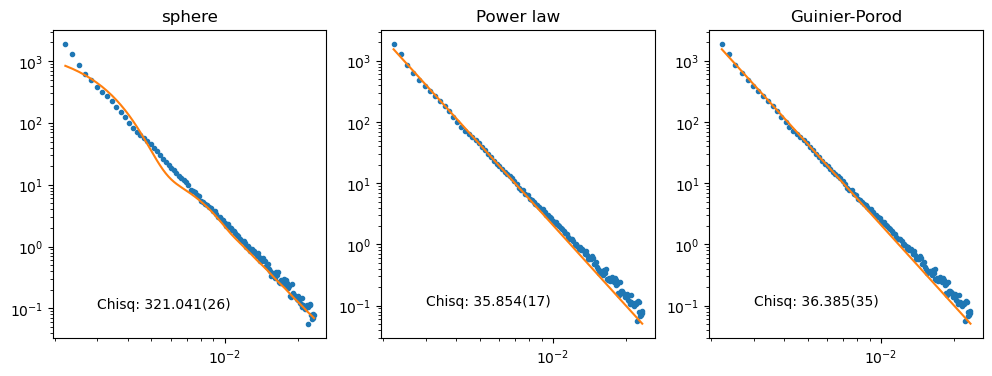

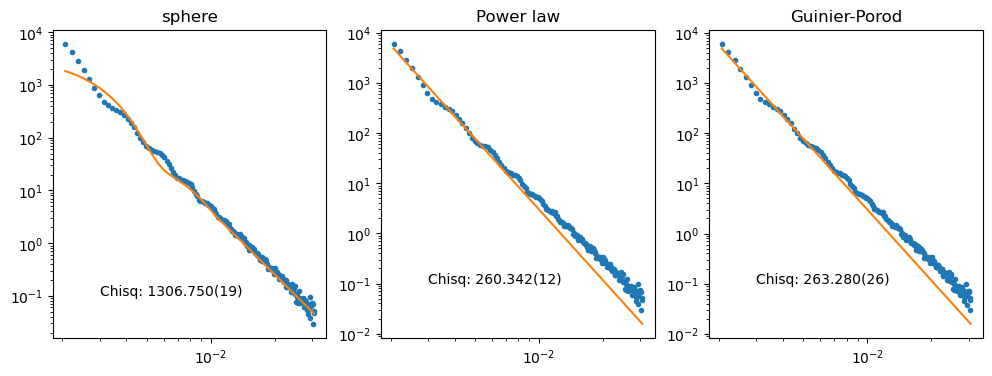

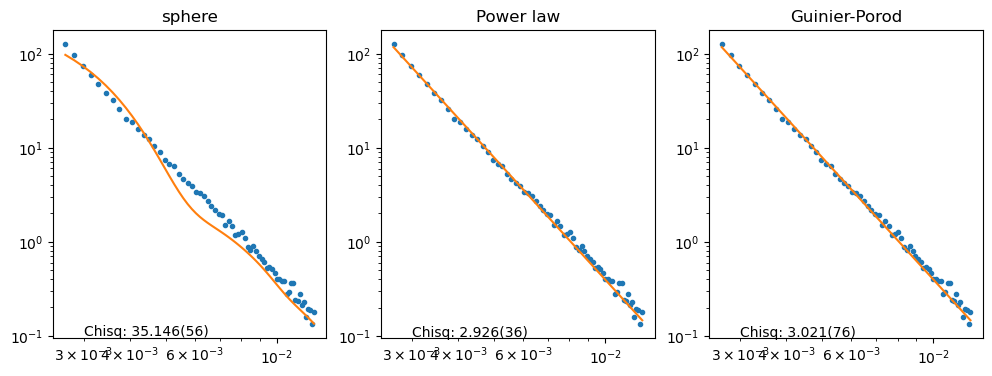

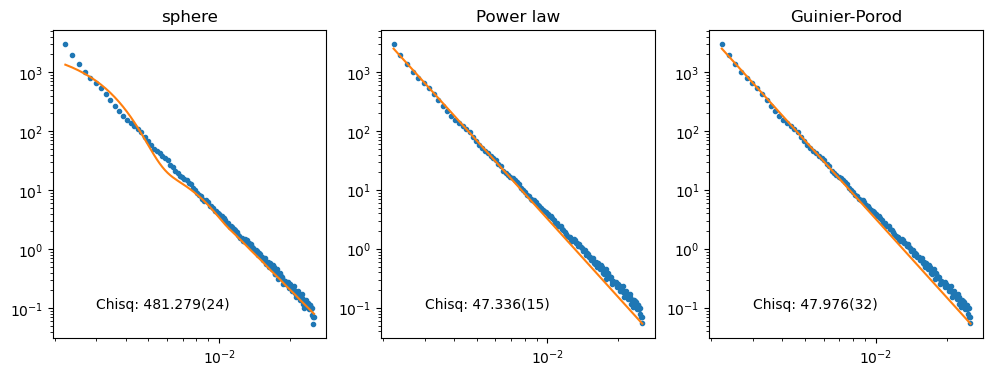

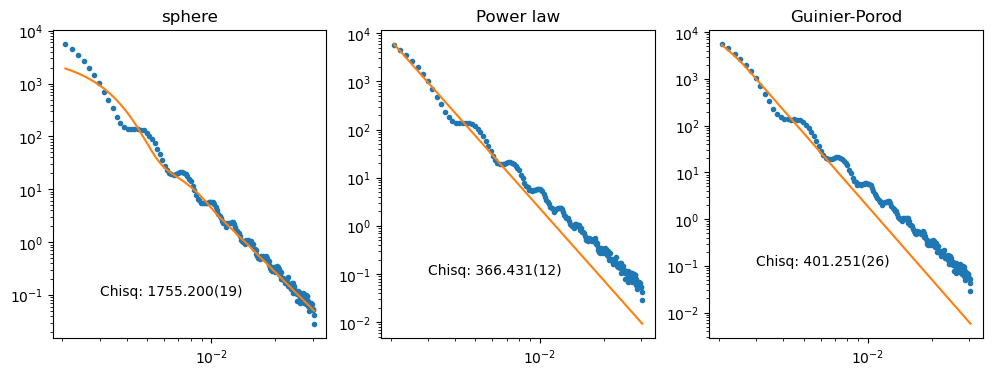

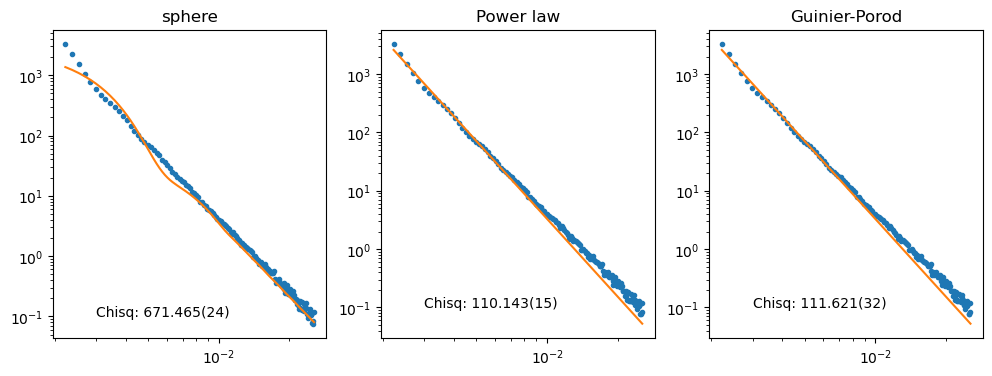

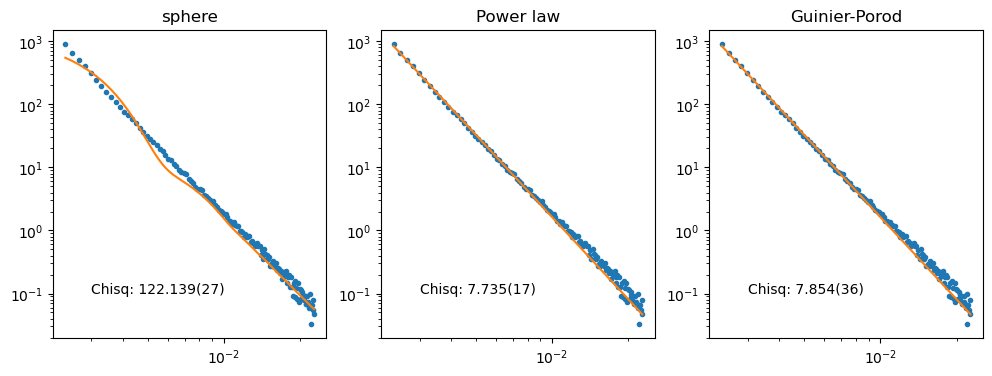

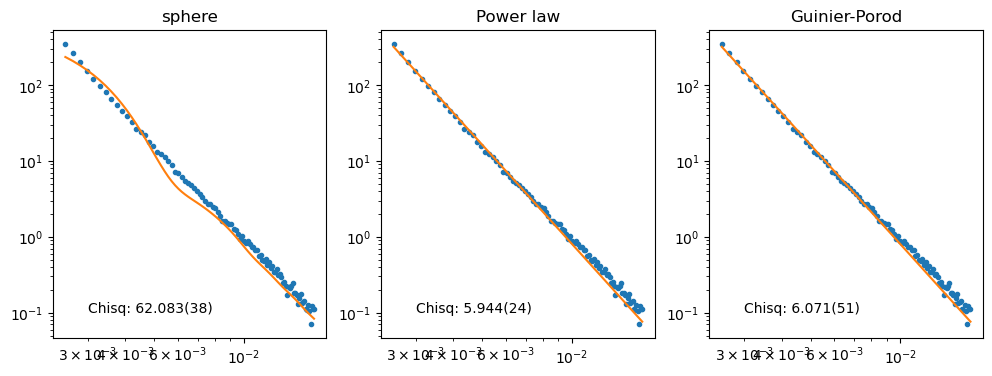

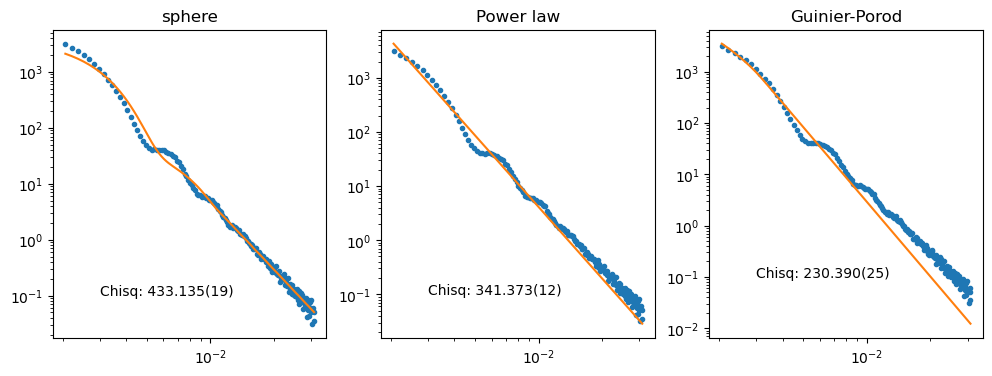

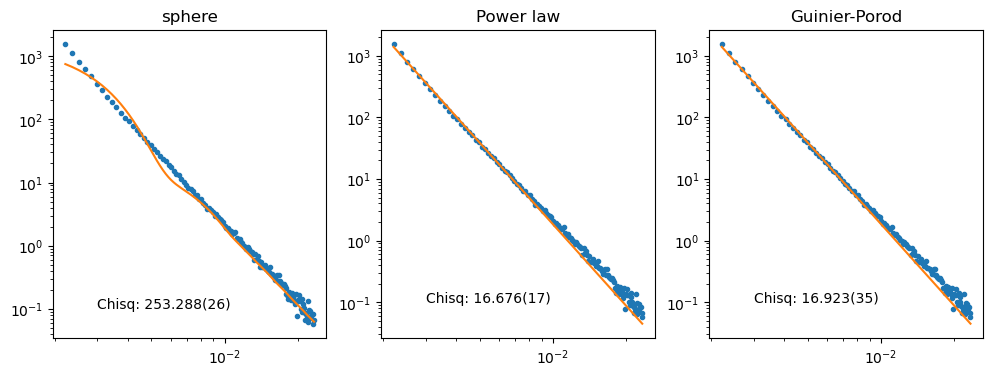

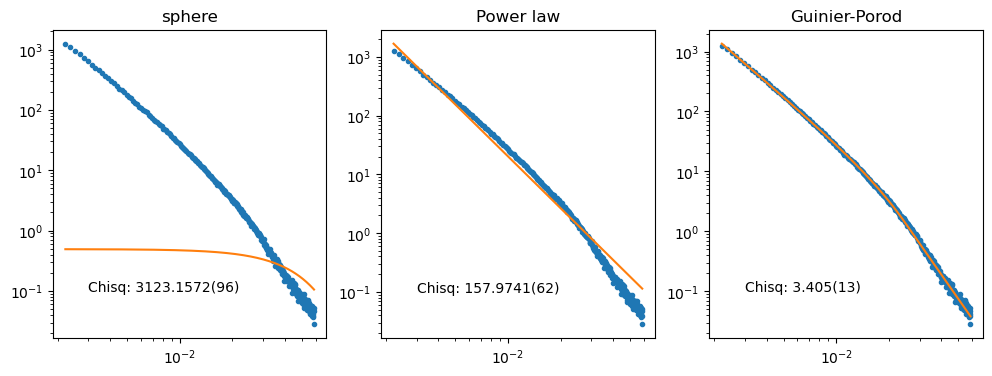

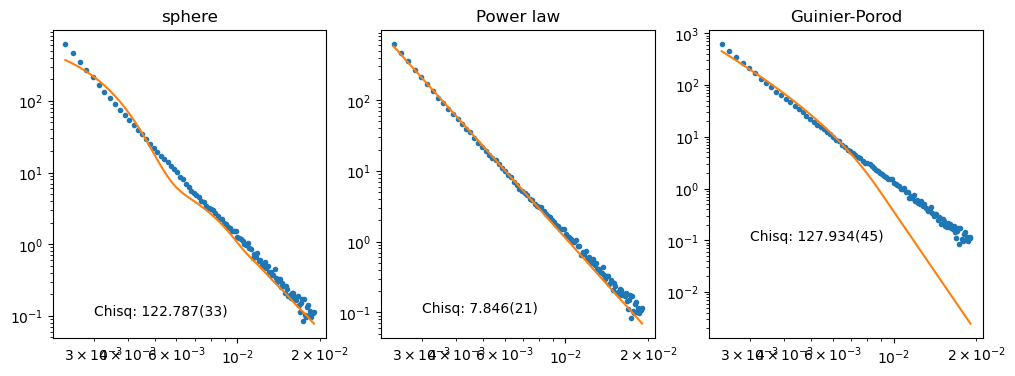

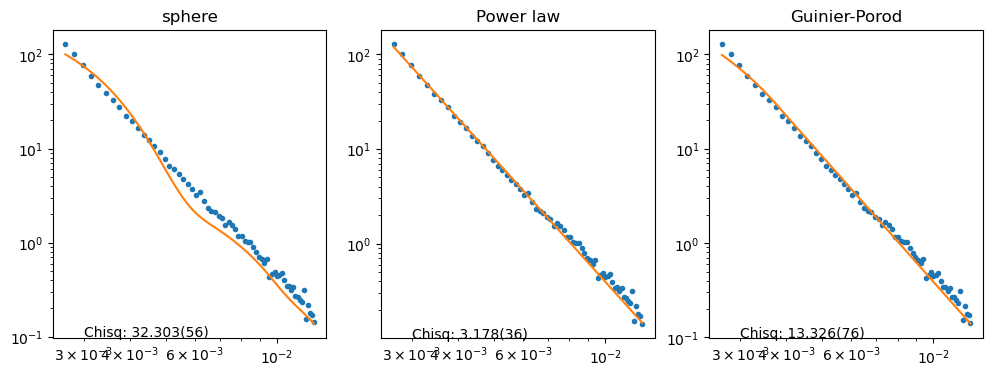

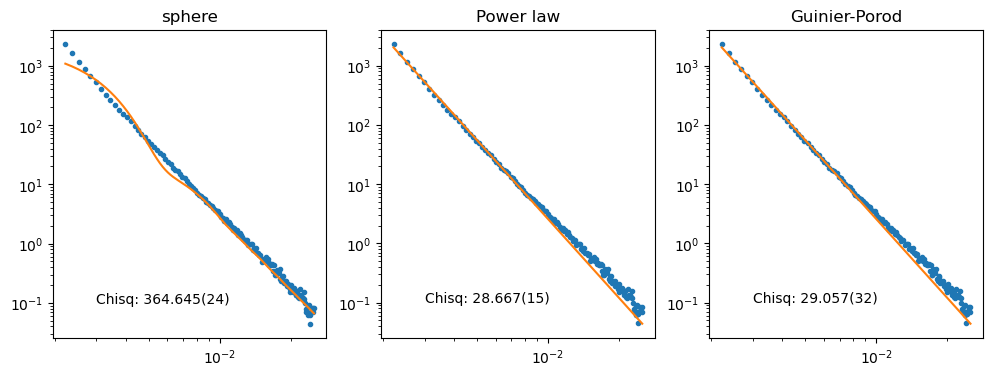

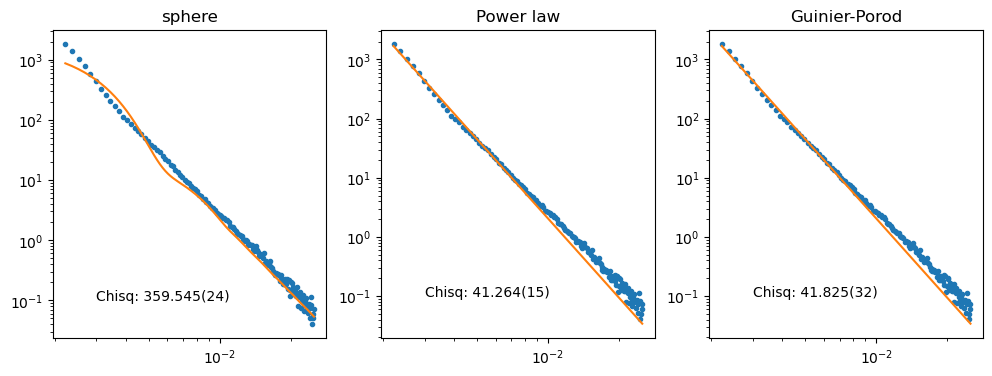

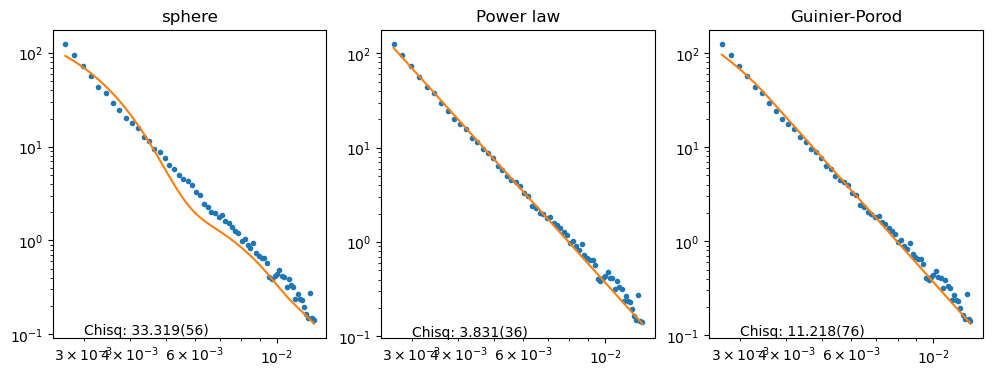

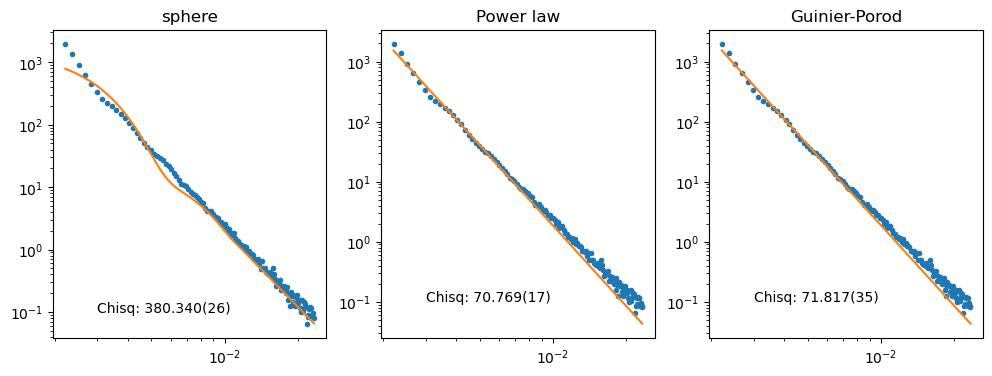

ValueError: Image size of 68949x379 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1200x400 with 3 Axes>

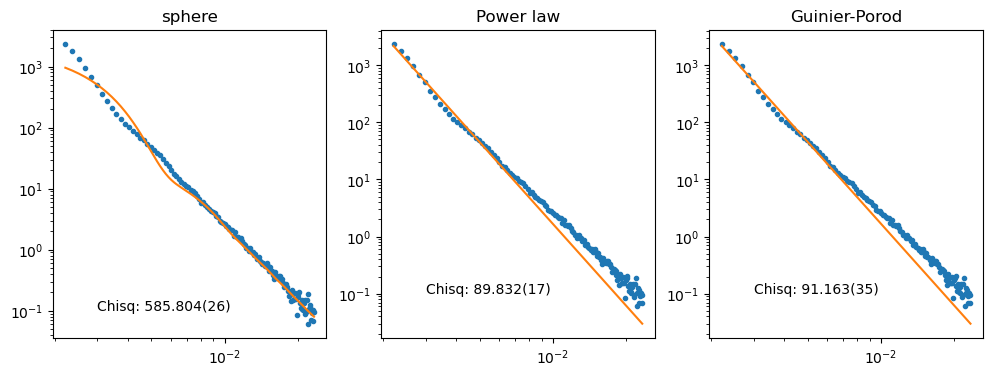

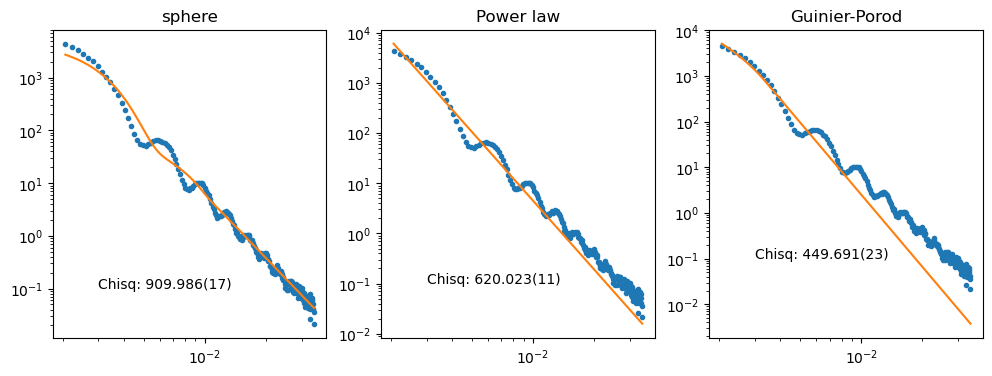

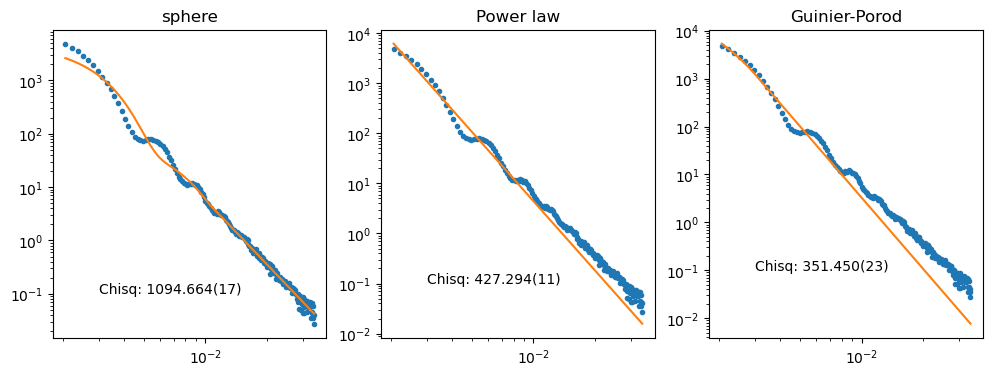

In [23]:
fit_results = {}
counter = 0
for uuid_val, signal in sample_data.items():
    print(f'Fitting sample {counter}')
    counter +=1
    background = uuid2bkg[uuid_val]

    results = saxs_fit_monofunc(signal[0], background[0])

    fit_results[uuid_val] = results
    

## Process fits, assign a value to each sample

In [24]:

fit_results_processed = {}
for uuid_val, result in fit_results.items():
    keys = []
    chisq = []
    if result is None:
        continue
    else:
            
        for key, val in result.items():
            keys.append(key)
            chisq.append(float(val['chisq'].split('(')[0]))
            best_fit = keys[np.argmin(chisq)]
        
        if best_fit == 'sphere_results':
            r = result['sphere_results']['radius']
            d_nm = r*2/10
            pdi = result['sphere_results']['radius_pd']
        
            sphere_results = {"best_fit":"sphere", "d_nm":d_nm, "pdi":pdi, "pl_power": None, 'd_gprg':None}
        
        if best_fit == 'power_law_results':
            power = result['power_law_results']['power']
            sphere_results = {'best_fit':"power_law", "d_nm":None, "pdi":None, "pl_power": power, 'd_gprg':None}
        
        if best_fit == 'guinierporod_results':
            rg = results['guinierporod_results']['rg']
            dg_nm = rg*2/10
            sphere_results = {'best_fit':"guinier_porod", "d_nm":None, "pdi":None, "pl_power": None, 'd_gprg':dg_nm}
        
        fit_results_processed[uuid_val] = sphere_results
    
    

In [26]:
len(fit_results_processed)

98

In [27]:
with open('sasview_fit_batch_2024_10_24.json', 'wt') as f:
    json.dump(fit_results_processed, f)

In [28]:
result['sphere_results']

{'radius': 689.455209293277,
 'radius_uncertainty': 0.659449627008584,
 'radius_pd': 0.19999999999999934,
 'radius_pd_uncertainty': 0.0008976311544934381,
 'scale': 0.0009207214099616461,
 'scale_uncertainty': 1.052257487821849e-06,
 'chisq': '1094.664(17)'}

In [29]:
result['guinierporod_results']['rg']

498.8946813706916